# Домашнее задание 8. Шмаков В.Е. ФФКЭ - гр. Б04-105

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from scipy.special import expit
from matplotlib import cm
from numba import njit

### Задача 4

Вспомним пример с шулерской монетой из семинара про теорему Байеса и регуляризацию.  В нём у нас были монеты, настоящие и шулерские. Настоящая при броске выпадала с одинаковой вероятностью на каждую грань, а шулерская монета только в 40% случаев выпадала орлом.

Этот опыт можно рассматривать как байесовскую классификацию.
Пусть у нас произошло N бросков и мы рассматриваем их результат как тест на определение типа монеты. Выполните следующие задания:

- В качестве начального априорного распределения положим равновероятный вариант иметь честную и шулерскую монету.  Постройте графики зависимости вероятности того, что монета шулерская, от числа k выпадения орла при фиксированных N. В качестве N возьмите N = 2, 3, 5; 10; 100.  
Указание: для n = 100 достаточно использовать центральную предельную теорему или формулу Стирлинга для вычисления факториалов.

- Постройте  ROC-кривую - кривую зависимости TPR от FPR при варьировании порога, то есть граничного значения величины k, при котором мы считаем, что монета является шулерской. Использовать N = 2, 3, 5; 10; 100.

- Постройте график функции AUC(N) - площади под ROC-кривой. Этот параметр является агрегированной характеристикой качества классификации, не зависящей от соотношения цен ошибок. Чем больше значение AUC, тем «лучше» модель классификации. Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.


In [18]:
class Bayes_Classifier:
    def __init__(self, p_real = 0.5, p_fake = 0.4, class_prop: list = [0.5, 0.5]):
        """Объект класса классификатора

        Args:
            p_real (float, optional): Вероятность выпадения настоящей монеты. Defaults to 0.5.
            p_fake (float, optional): Вероятность выпадения шуллерской монеты. Defaults to 0.4.
            class_prop (list, optional): Априорная вероятности того что монета настоящая или шуллерская
        """
        self.p_real, self.p_fake = p_real, p_fake
        self.class_prop = np.copy(class_prop)
    def __get_prop_by_result__(self, result, prop):
        return abs(int(not result) - prop)
    def fit(self, x: np.ndarray):
        """Обновляет вероятности 

        Args:
            x (np.ndarray): Выборка
        """
        for result in x:
            class_prop_0_new = self.__get_prop_by_result__(result, self.p_real) * self.class_prop[0] / (self.class_prop[0] * self.__get_prop_by_result__(result, self.p_real) + self.class_prop[1] * self.__get_prop_by_result__(result, self.p_fake))
            class_prop_1_new = self.__get_prop_by_result__(result, self.p_fake) * self.class_prop[1] / (self.class_prop[0] * self.__get_prop_by_result__(result, self.p_real) + self.class_prop[1] * self.__get_prop_by_result__(result, self.p_fake))
            self.class_prop = [class_prop_0_new, class_prop_1_new]        
    def get_real_propability(self):
        return self.class_prop[0]
    def get_fake_propability(self):
        return self.class_prop[1] 
               

In [51]:
model = Bayes_Classifier()
model.fit([1])
print(model.get_fake_propability())

0.4444444444444445


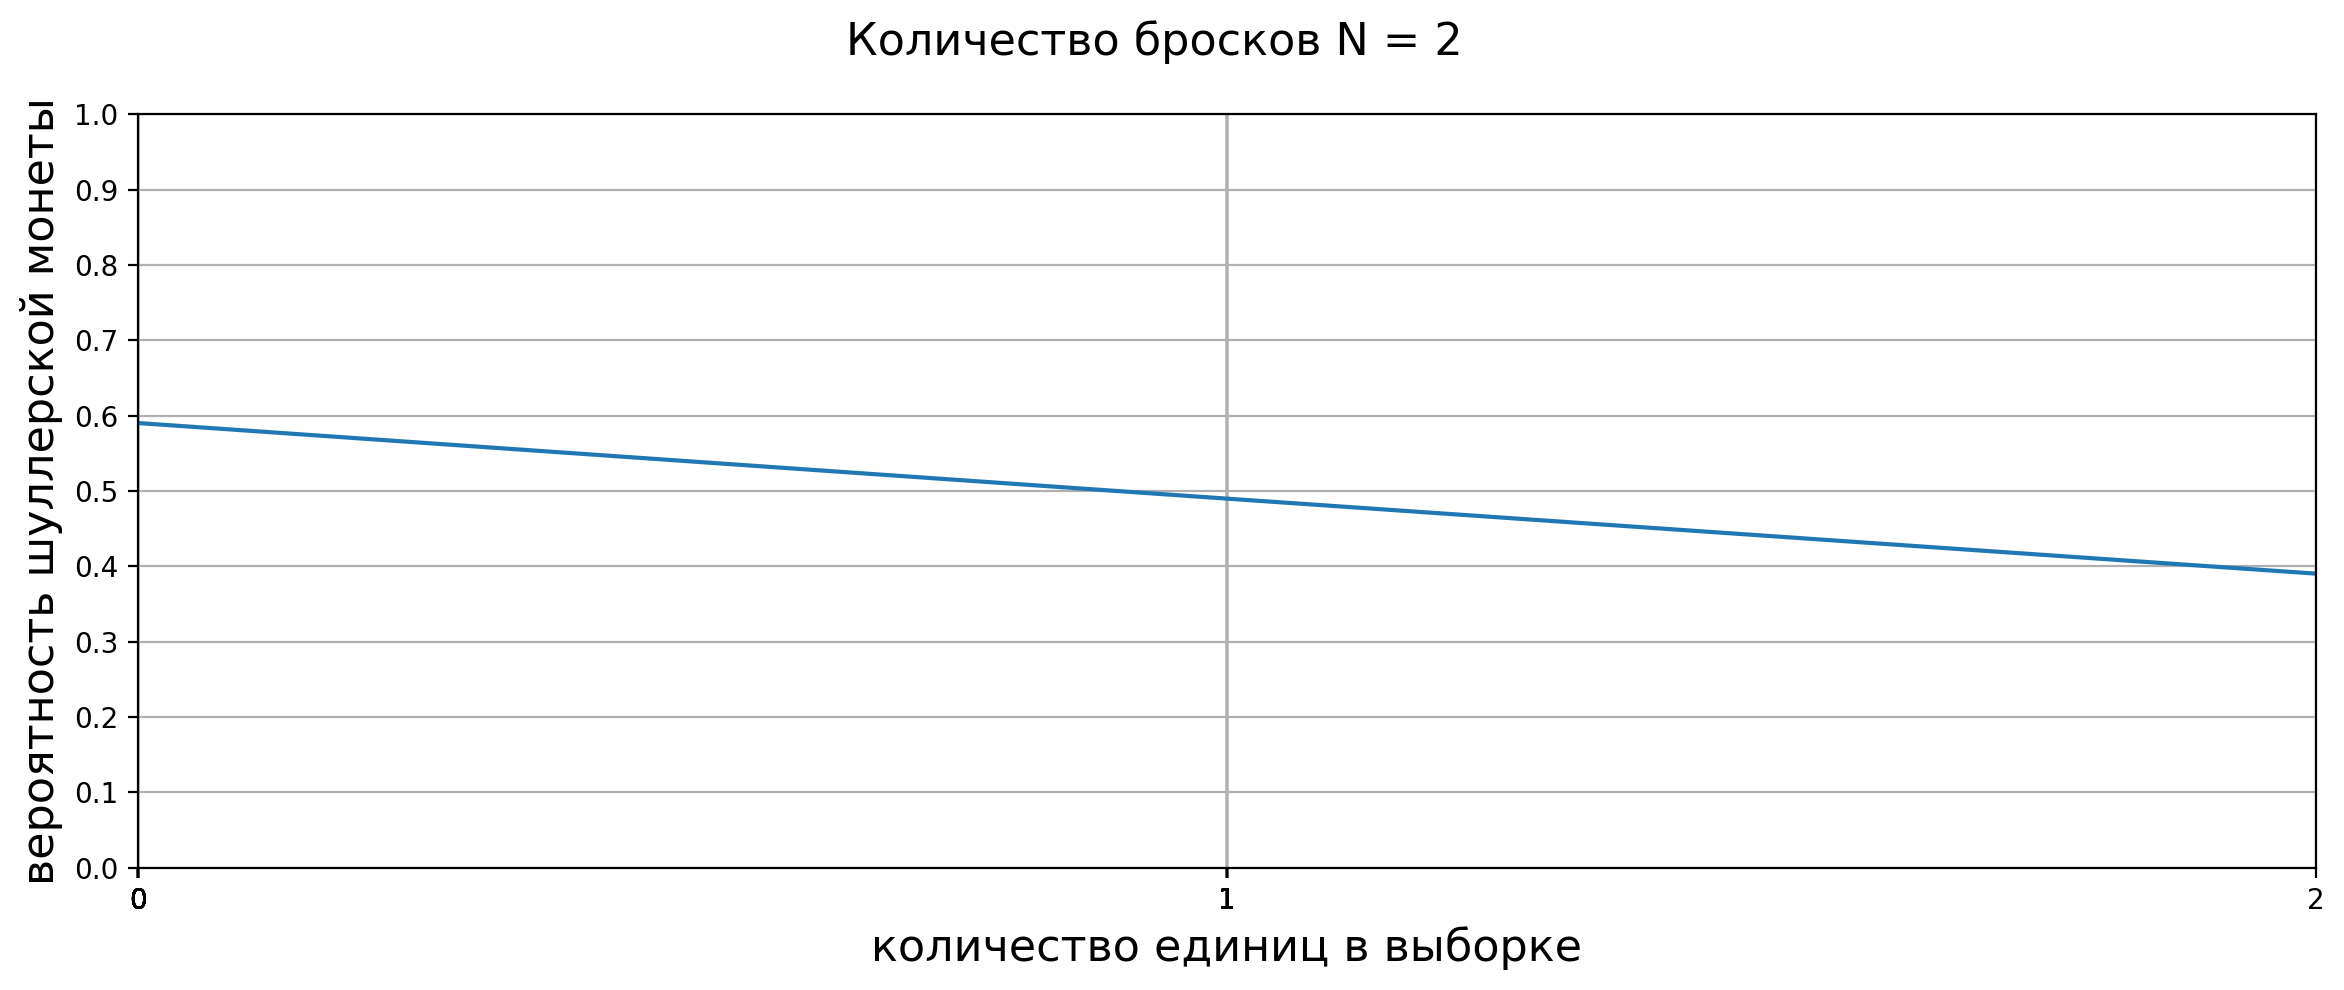

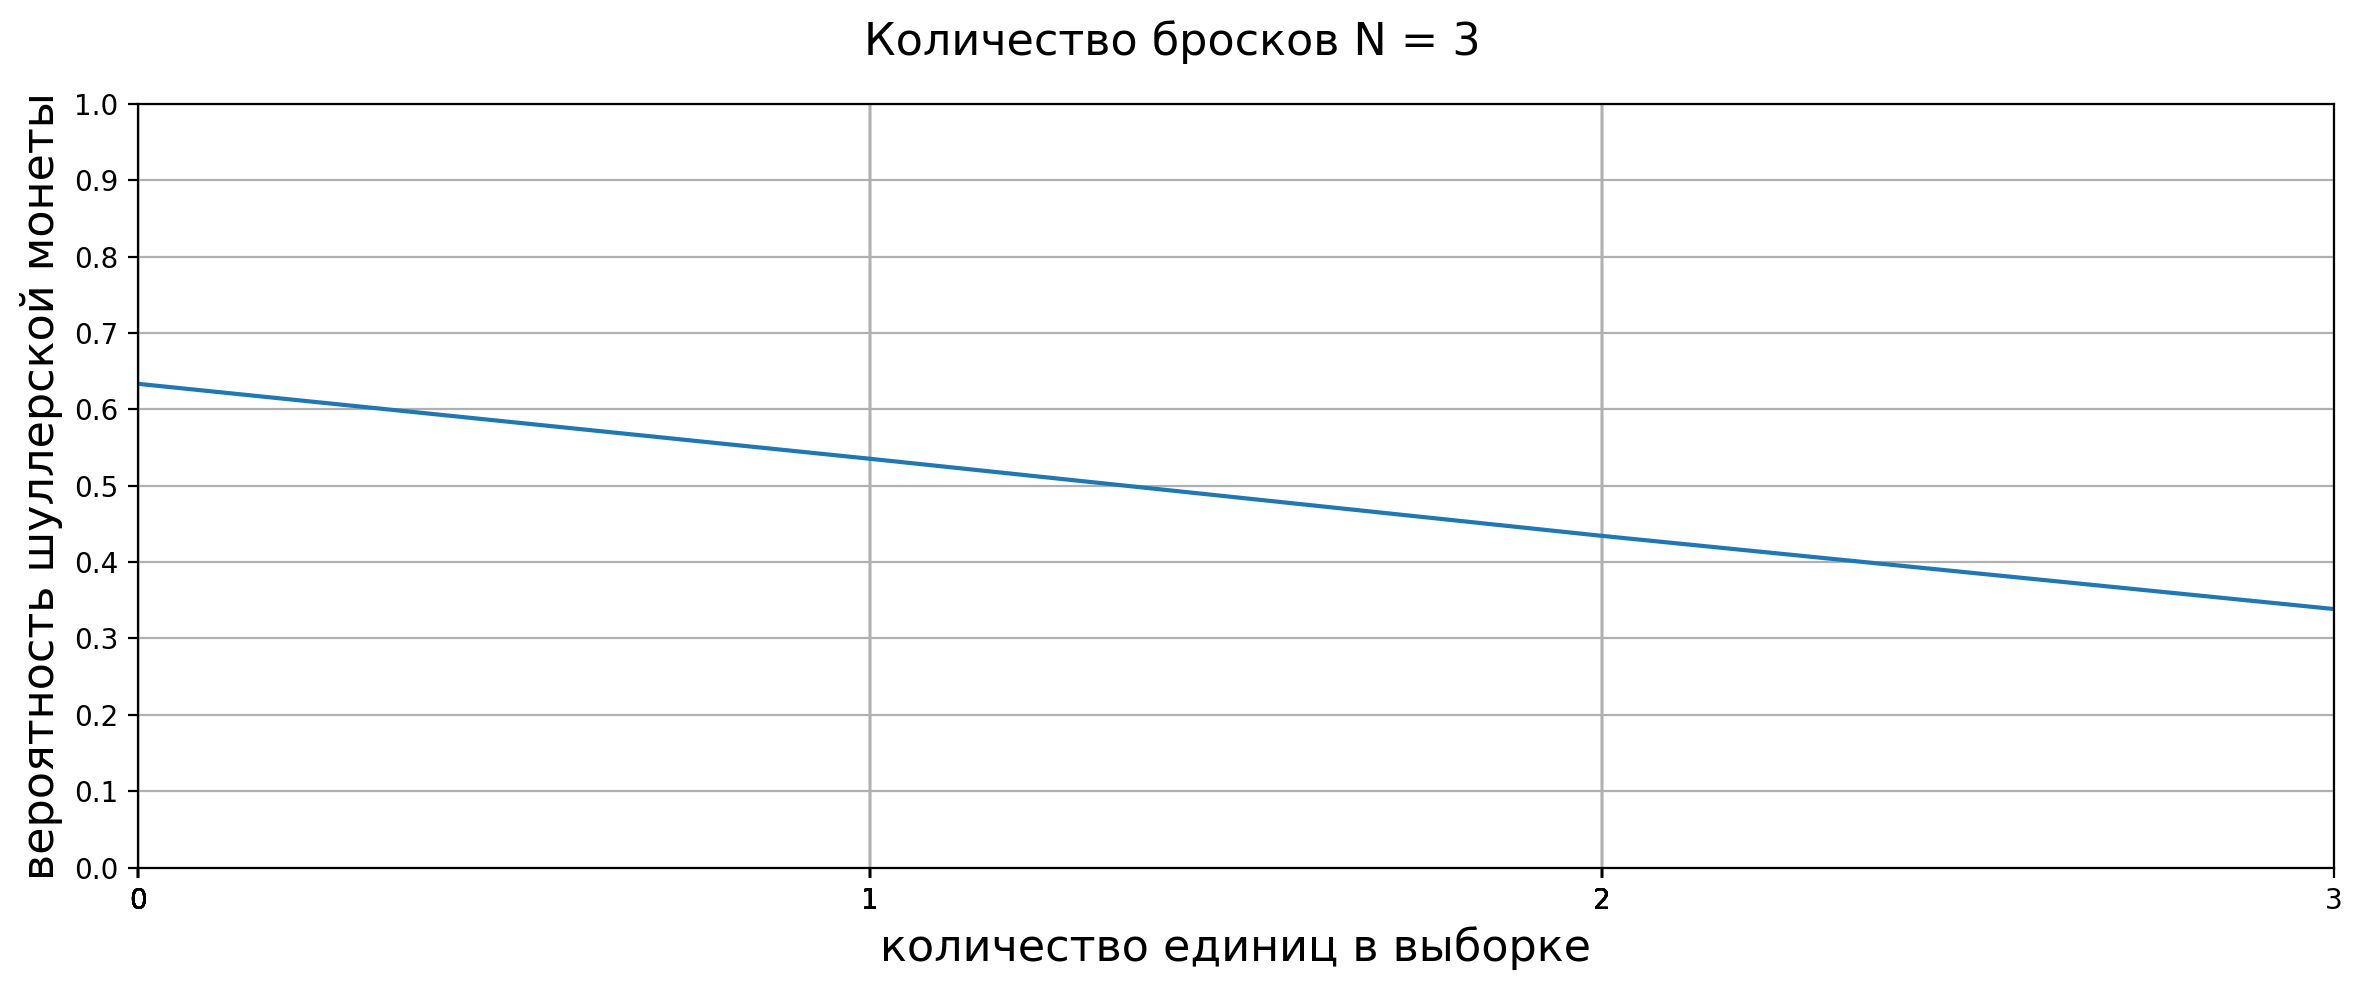

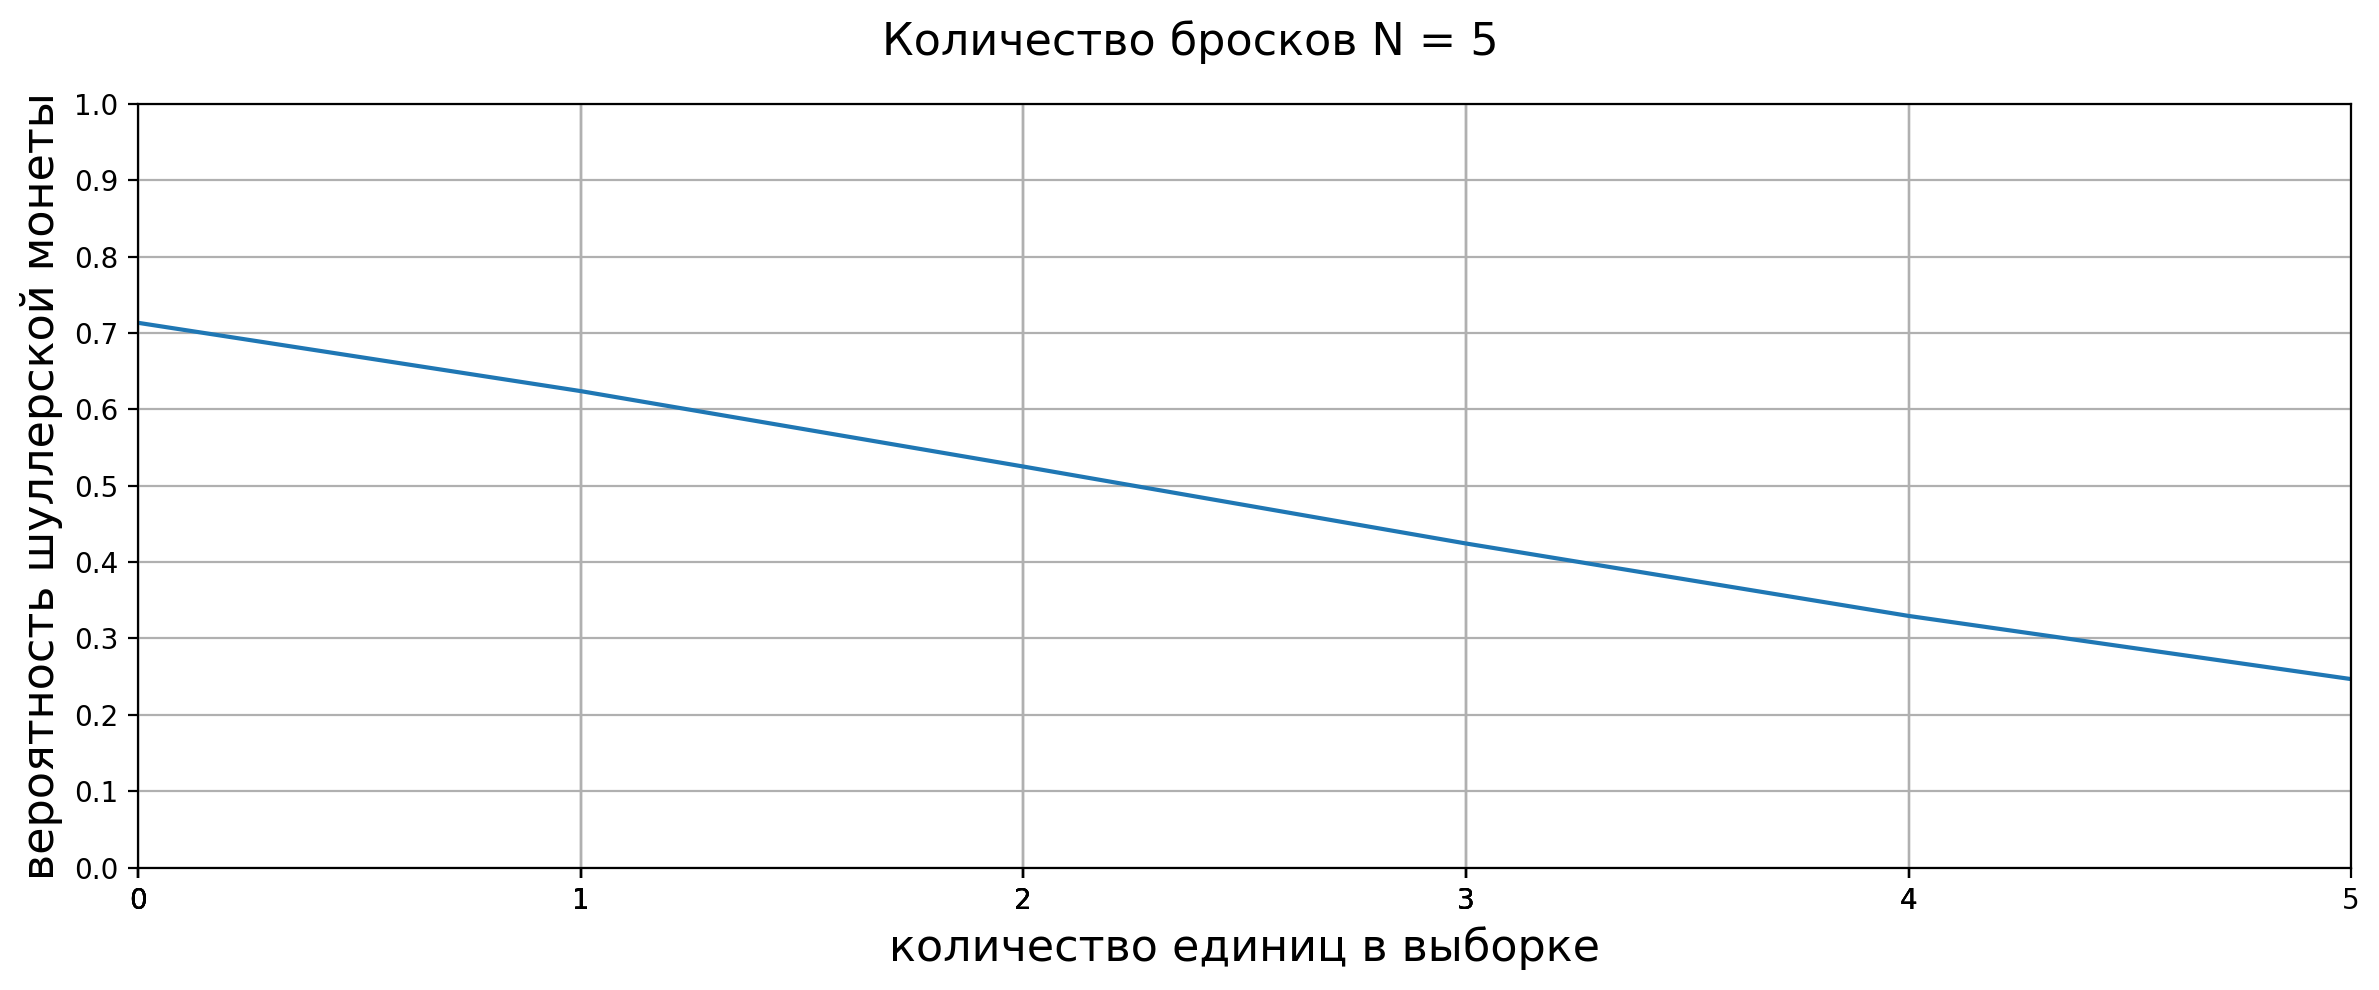

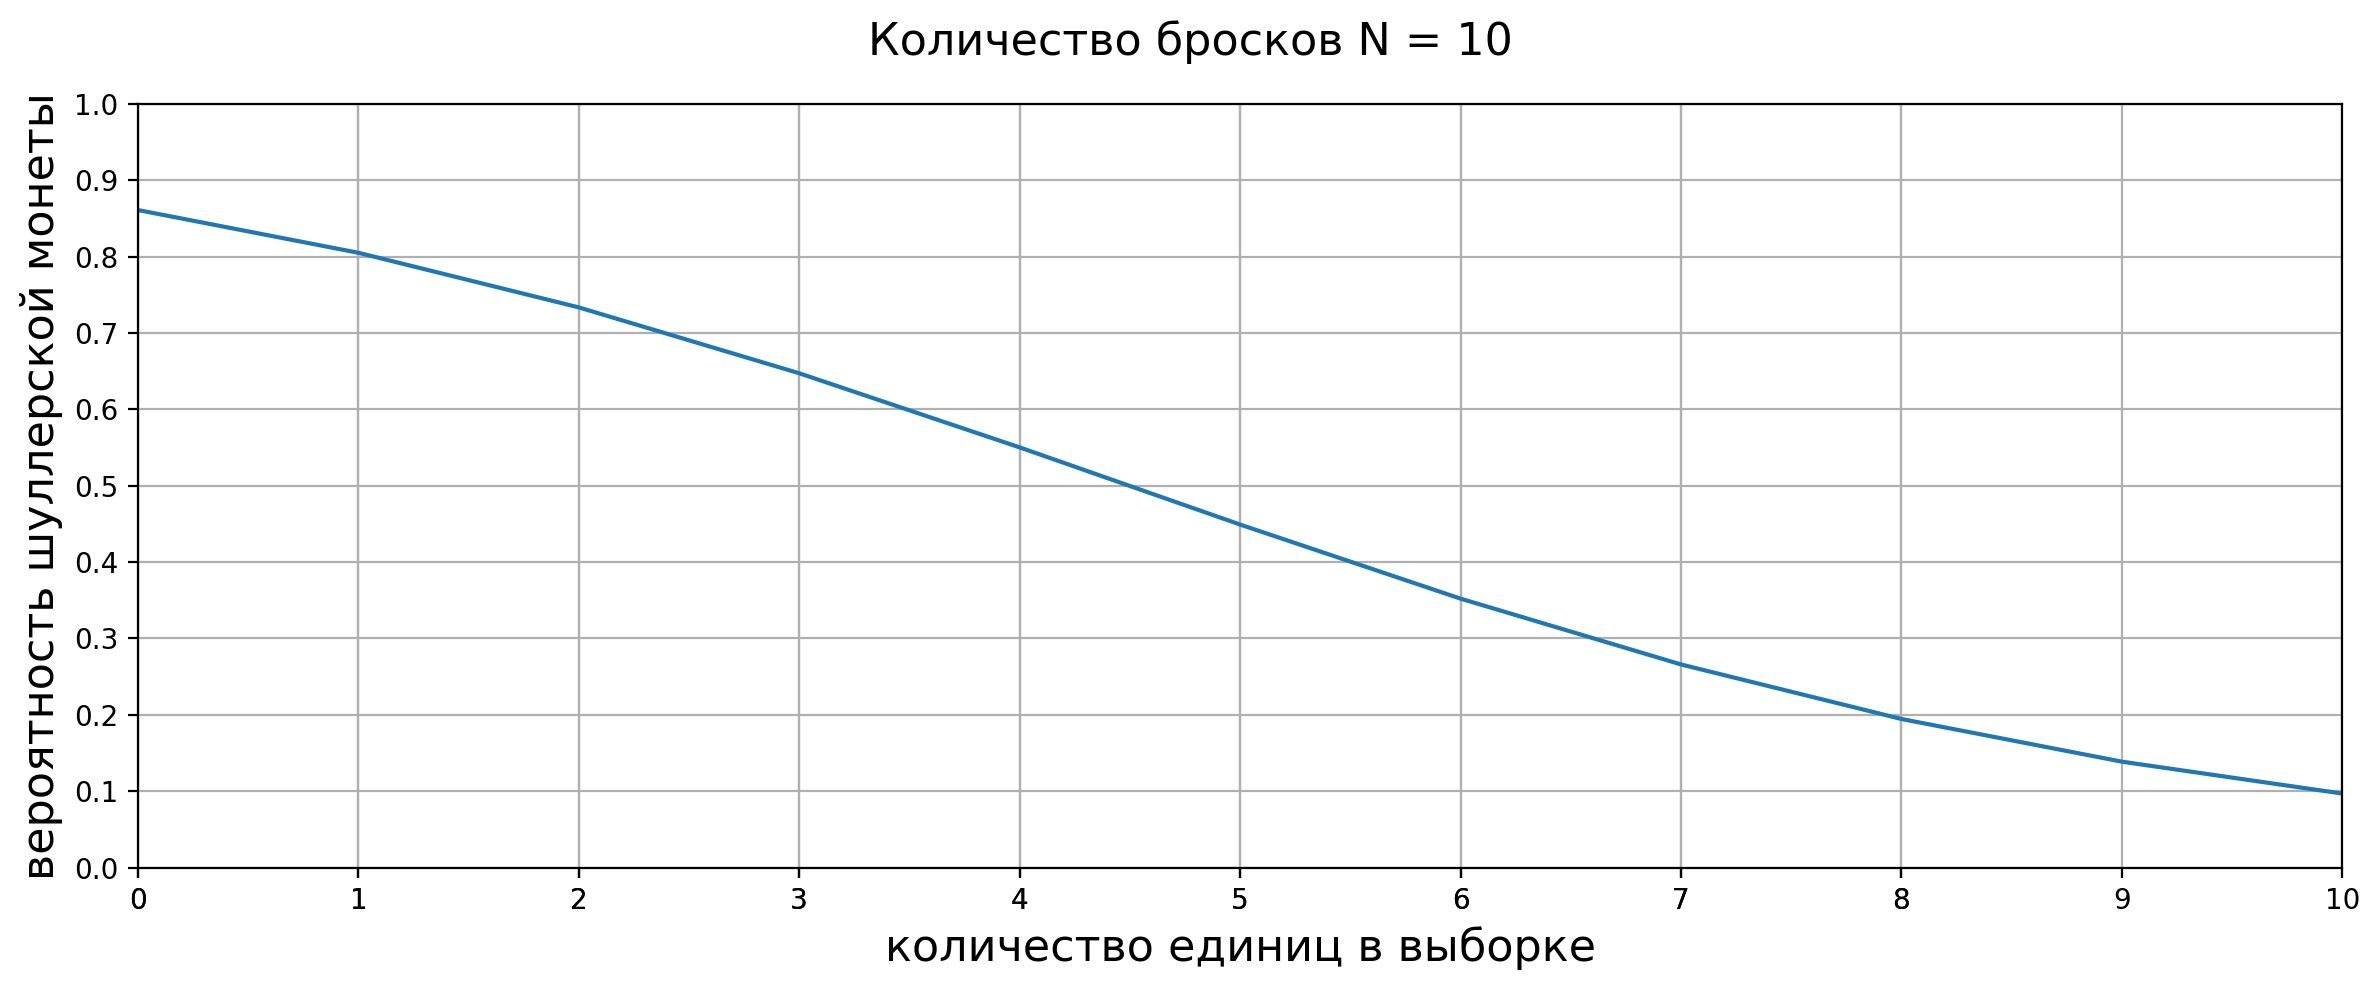

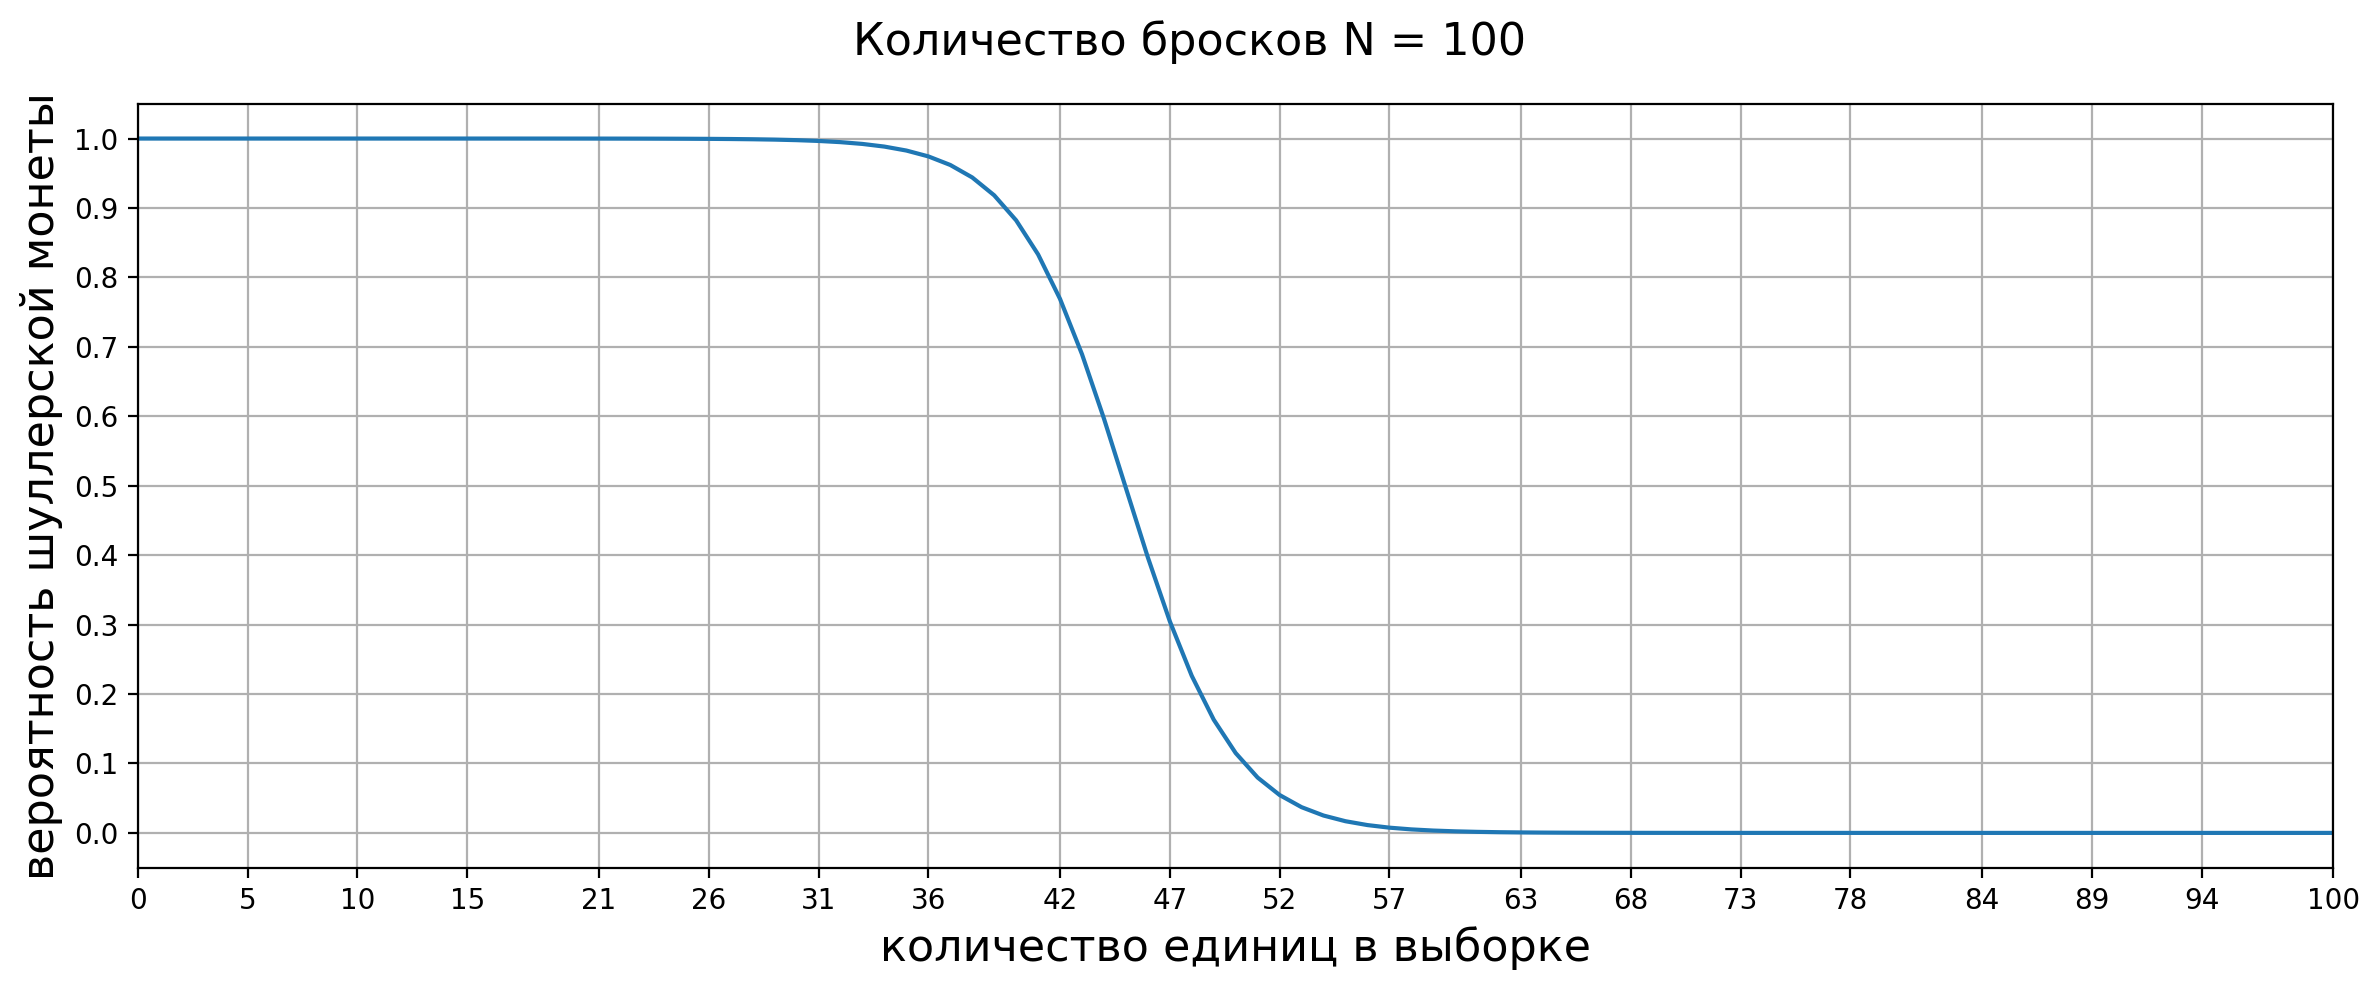

In [50]:
N_values = [2, 3, 5, 10, 100] #число бросков
tau_values = np.linspace(0, 1, 20)

for N in N_values:
    fig, ax = plt.subplots(1, 1, figsize = (12, 5), dpi = 200)
    k_values = np.arange(N + 1)
    fake_prop_values = []
    for k in k_values:
        sample = np.hstack([np.ones(k), np.zeros(N - k)]) 
        model = Bayes_Classifier()
        model.fit(sample)
        fake_prop_values.append(model.get_fake_propability())
    plt.plot(k_values, fake_prop_values)
    fig.suptitle(f"Количество бросков N = {N}", fontsize = 16)
    plt.xlabel("количество единиц в выборке", fontsize = 16)
    plt.ylabel("вероятность шуллерской монеты", fontsize = 16)
    plt.grid()
    plt.xlim(0, N)
    plt.xticks(np.linspace(0, N, 20, dtype = np.int64))
    fig.tight_layout()  
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    
    

### Задача 5 - метод k ближайших соседей для Ирисов Фишера

Используйте евклидову метрику на нормализованных данных по всем 4-м признакам.

$$
x_i \equiv \frac{x_i-\bar{x}}{s}
$$

$$
\bar{x}=\frac{1}{n} \sum_{i=1}^n x_i
$$


$$
\mathrm{s}=\cdot \sqrt{\frac{1}{n-1} \sum_{i=1}^n\left(x_i-\bar{x}\right)^2}
$$

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  - реализовано здесь.

- Поочередно рассматривайте каждый цветок, считая его тип неизвестным, а типы всех остальных цветков известными, и определите для каждого цветка, правильно определён тип цветка или неправильно.

- Постройте зависимость количества правильно определённых цветков от k.

- При каком k максимальное количество правильно определённых по типу цветков?


Указания к выполнению:

- можно реализовывать вручную, а можно с помощью библиотеки https://scikit-learn.ru/1-6-nearest-neighbors/

- на Хабре есть статья про kNN на примере ирисов Фишера https://habr.com/ru/articles/680004/, можете использовать куски кода оттуда, если возникают проблемы с реализацией

- также в папке семинара есть файл с лекцией МФТИ по kNN алгоритму и там тоже сделана реализация под ирисы Фишера. Код можно использовать для решения предложенной задачи.


In [ ]:
data = sns.load_dataset('iris')
# data.drop(['sepal_length', 'sepal_width'], inplace = True, axis = 1)
data.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [ ]:
data['species'] = preprocessing.LabelEncoder().fit_transform(data['species'])
data.head()

sepal_length  sepal_width  petal_length  petal_width  species
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

In [ ]:
X, y = data.drop('species', axis = 1, inplace = False), data['species']
X, y = X.to_numpy(), y.to_numpy()

In [ ]:

k_values = np.arange(X.shape[0] // 2) + 1
true_predictions_num = np.zeros_like(k_values)
for ind, k in enumerate(k_values):
    for test_ind in range(X.shape[0]):
        train_indicies_mask = np.arange(X.shape[0]) != test_ind
        X_train, y_train = X[train_indicies_mask], y[train_indicies_mask]
        X_test, y_test = X[test_ind], y[test_ind]
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        model = KNeighborsClassifier(n_neighbors = k).fit(X_train_scaled, y_train)
        y_prediction = model.predict(scaler.transform([X_test]))
        true_predictions_num[ind] += y_prediction == y_test

(1.0, 75.0)

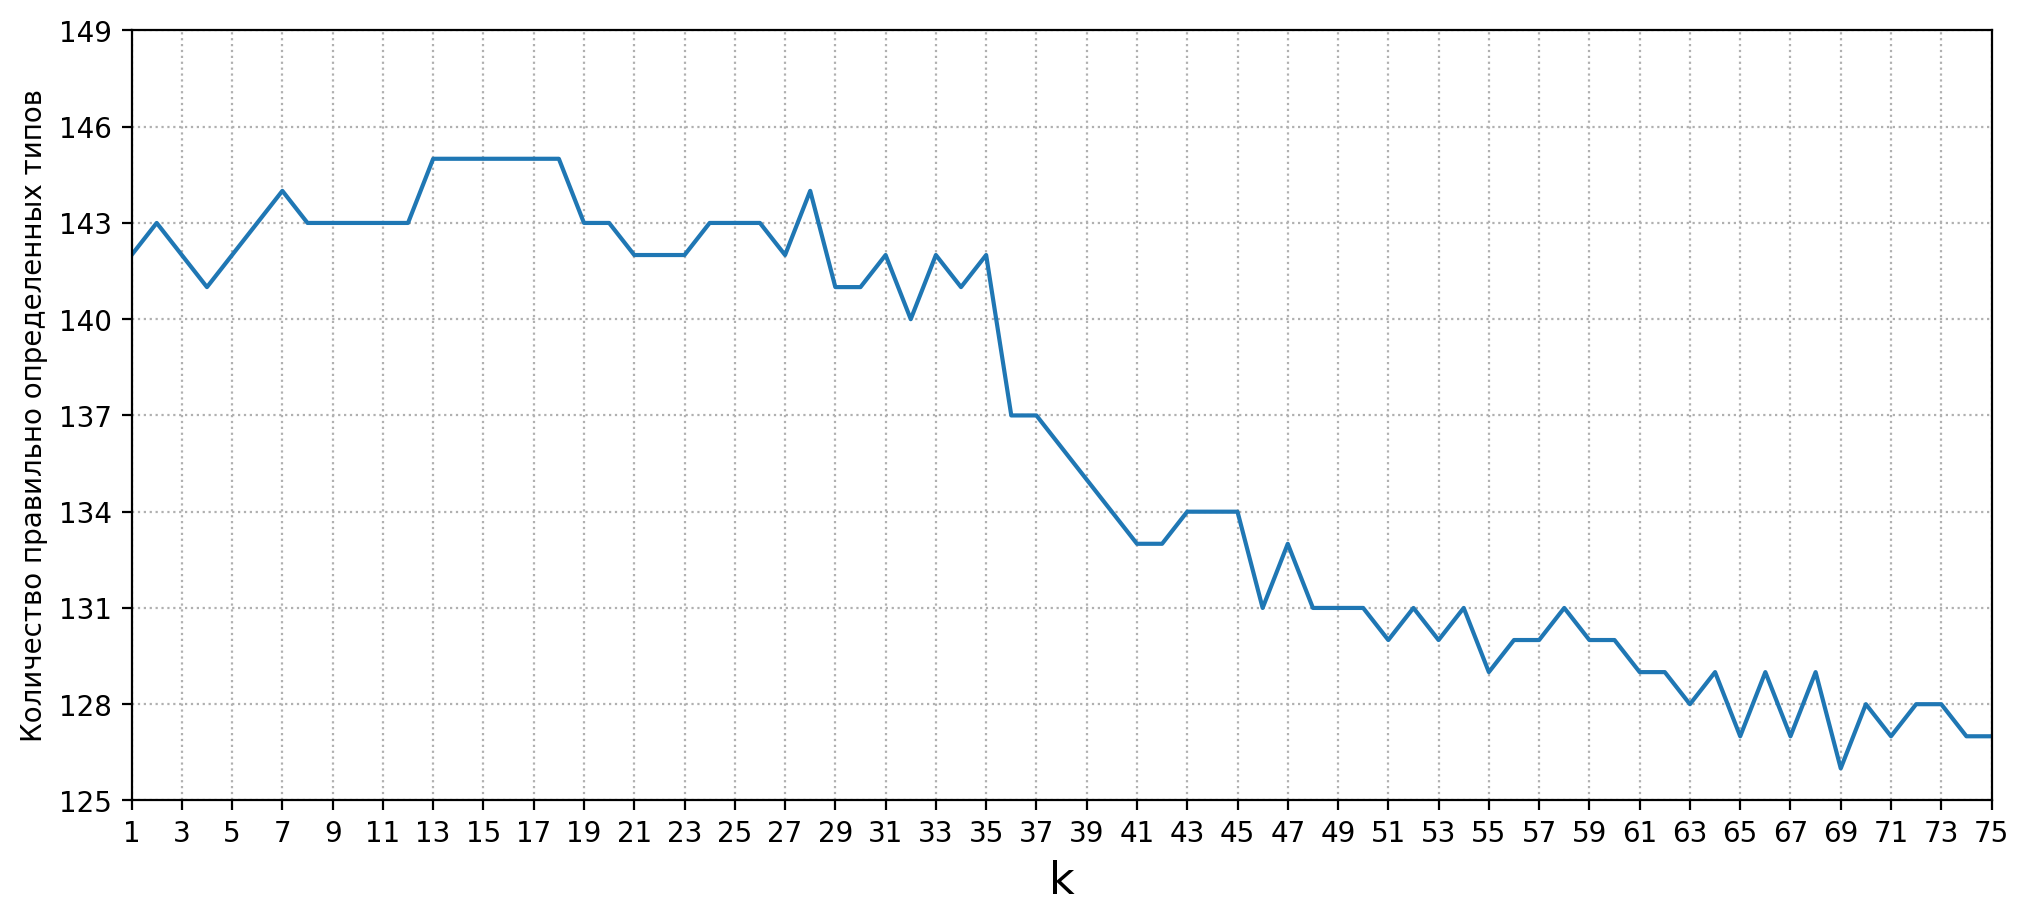

In [ ]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.plot(k_values, true_predictions_num)
plt.grid(ls = ':')
plt.xlabel("k", fontsize = 16)
plt.ylabel("Количество правильно определенных типов", fontsize = 10)
plt.yticks(np.arange(125, 150, 3))
plt.xticks(np.arange(1, np.max(k_values) + 5, 2))
plt.xlim(1, np.max(k_values))

__Вывод__

Как видим, оптимальное значение $k$ лежит в диапазоне от 13 до 18. Полученное значение практически совпадает с <<компромиссным>>:
$$
\sqrt{N} = \sqrt{150} \sim 12
$$

### Задача 6* - Логистическая регрессия с регуляризацией и стохастическим градиентным спуском

__Загрузка данных, преобразование категориальных признаков__

In [ ]:
data = pd.read_csv("dataset.csv", low_memory = False)
data = data.loc[data['pha'].notnull()]
print(data.pha.unique())
data.head()

['N' 'Y']


id    spkid       full_name pdes     name prefix neo pha     H  \
0  a0000001  2000001         1 Ceres    1    Ceres    NaN   N   N  3.40   
1  a0000002  2000002        2 Pallas    2   Pallas    NaN   N   N  4.20   
2  a0000003  2000003          3 Juno    3     Juno    NaN   N   N  5.33   
3  a0000004  2000004         4 Vesta    4    Vesta    NaN   N   N  3.00   
4  a0000005  2000005       5 Astraea    5  Astraea    NaN   N   N  6.90   

   diameter  ...       sigma_i      sigma_om       sigma_w      sigma_ma  \
0   939.400  ...  4.608900e-09  6.168800e-08  6.624800e-08  7.820700e-09   
1   545.000  ...  3.469400e-06  6.272400e-06  9.128200e-06  8.859100e-06   
2   246.596  ...  3.223100e-06  1.664600e-05  1.772100e-05  8.110400e-06   
3   525.400  ...  2.170600e-07  3.880800e-07  1.789300e-07  1.206800e-06   
4   106.699  ...  2.740800e-06  2.894900e-05  2.984200e-05  8.303800e-06   

       sigma_ad       sigma_n      sigma_tp     sigma_per  class      rms  
0  1.111300e-11  1.196500e-12  3.782900e-08  9.415900e-09    MBA  0.43301  
1  4.961300e-09  4.653600e-10  4.078700e-05  3.680700e-06    MBA  0.35936  
2  4.363900e-09  4.413400e-10  3.528800e-05  3.107200e-06    MBA  0.33848  
3  1.648600e-09  2.612500e-10  4.103700e-06  1.274900e-06    MBA  0.39980  
4  4.729000e-09  5.522700e-10  3.474300e-05  3.490500e-06    MBA  0.52191  

[5 rows x 45 columns]

In [ ]:
data = data.drop(['id', 'spkid', 'full_name', 'pdes',
                  'name', 'prefix', 'neo', 'orbit_id',
                  'equinox', 'class'], axis=1)

# переведем таргет в столбец 0 и 1
data['pha'] = preprocessing.LabelEncoder().fit_transform(data['pha'])

In [ ]:
for key in data.keys():
    if key[:5]=='sigma':
        data.drop(key, inplace = True, axis = 1)

In [ ]:
print(data.pha.unique())

[0 1]


__Удаление выбросов и обработка пропусков__

In [ ]:
print(len(data.keys()))

24


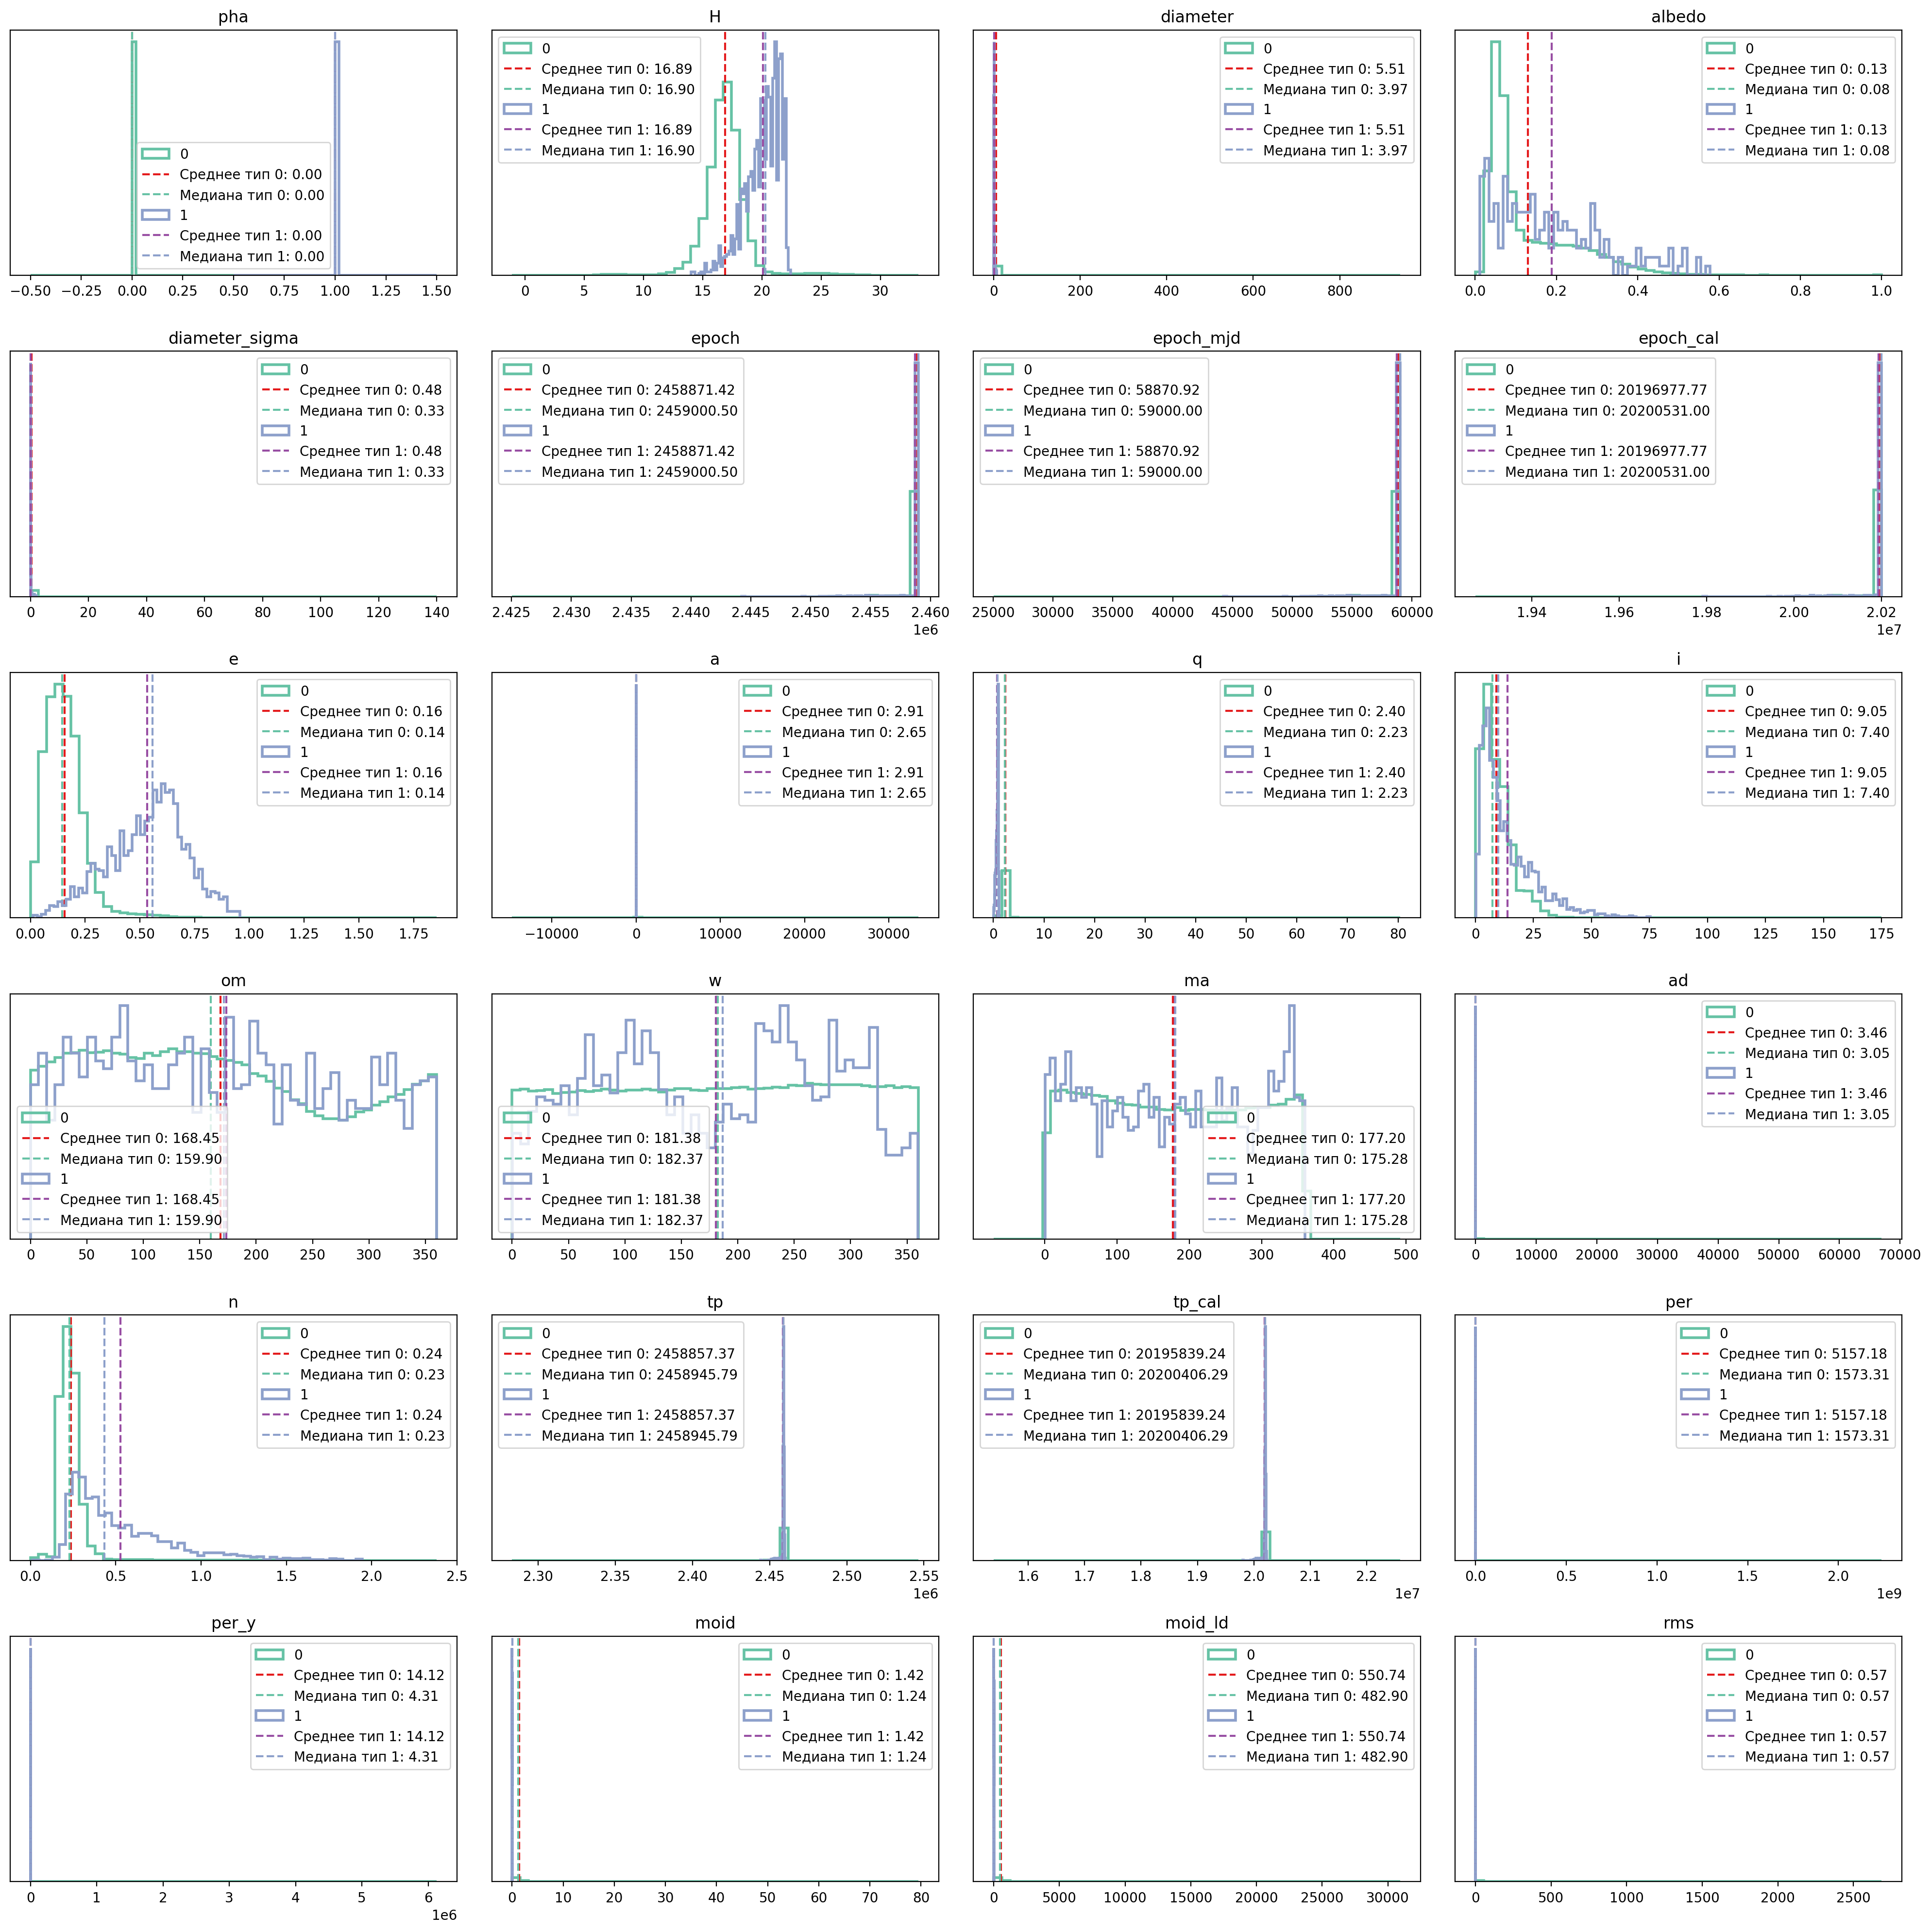

In [ ]:
fig, ax = plt.subplots(6, 4, figsize = (20, 20), dpi = 200)
for ind, (key, col) in enumerate(data.items()):
    plotable = ax[ind // 4][ind % 4]
    plotable.set_title(key)
    for ind_type, type in enumerate(data.pha.unique()):
        mask = data.pha == type
        if np.sum(col[mask].isna()) == len(col[mask]):
            break; 
        plotable.hist(col[mask], 
                      bins = 50, 
                      density = True, 
                      histtype = 'step', 
                      color = cm.Set2(ind_type / 3),
                      linewidth = 2,
                      label = type)
        plotable.set_yticks([])
        plotable.axvline(np.mean(col[mask]), 
                         color = cm.Set1(ind_type / 3), 
                         label = f'Среднее тип {type}: {np.mean(col.dropna(inplace = False)):.2f}',
                         linestyle = '--')
        plotable.axvline(np.median(col[mask]), 
                         color = cm.Set2(ind_type / 3), 
                         label = f'Медиана тип {type}: {np.median(col.dropna(inplace = False)):.2f}',
                         linestyle = '--')
        plotable.legend()
fig.tight_layout()

Как видим, признаки `moid`, `albedo`, `diametr_sigma` не имеют данных для типа 3. Данные признаки не могут быть полезны для классификации. Соответственно такие признаки бесполезны для последующей классификации. Удалим их

In [ ]:
data.drop(['moid', 'albedo', 'diameter', 'diameter_sigma'], axis = 1, inplace = True)

In [ ]:
print(data.shape)

(938603, 20)


Как видим, при удалении выбросов мы удалили достаточно большую часть данных

In [ ]:
print(data.isna().sum() / data.shape[0])

pha          0.000000
H            0.006672
epoch        0.000000
epoch_mjd    0.000000
epoch_cal    0.000000
e            0.000000
a            0.000000
q            0.000000
i            0.000000
om           0.000000
w            0.000000
ma           0.000001
ad           0.000004
n            0.000000
tp           0.000000
tp_cal       0.000000
per          0.000004
per_y        0.000001
moid_ld      0.000000
rms          0.000001
dtype: float64


In [ ]:
data = data.dropna()
print(data.isna().sum() / data.shape[0])

pha          0.0
H            0.0
epoch        0.0
epoch_mjd    0.0
epoch_cal    0.0
e            0.0
a            0.0
q            0.0
i            0.0
om           0.0
w            0.0
ma           0.0
ad           0.0
n            0.0
tp           0.0
tp_cal       0.0
per          0.0
per_y        0.0
moid_ld      0.0
rms          0.0
dtype: float64


Сравнивая медиану и среднее значение каждого из признаков, а также рассматривая диапазон в котором построенна гистограмма найдём выбросы. Выбросы присутствуют в колонках `epoch_mjd`, `a`, `q`, `ad`, `per`, `per_y`, `rms`, `moid_ld`

In [ ]:
print(data.keys())

Index(['pha', 'H', 'epoch', 'epoch_mjd', 'epoch_cal', 'e', 'a', 'q', 'i', 'om',
       'w', 'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid_ld', 'rms'],
      dtype='object')


In [ ]:
diapasons = {'epoch_mjd': (52000, 70000),
             'a': (0, 1000),
             'q': (0, 10),
             'per_y': (0, 5),
             'rms': (0, 3)}

for key in diapasons.keys():
    data = data[data[key] < diapasons[key][1]]
    data = data[data[key] > diapasons[key][0]]

Удостоверимся, что в данных отсутствуют выбросы

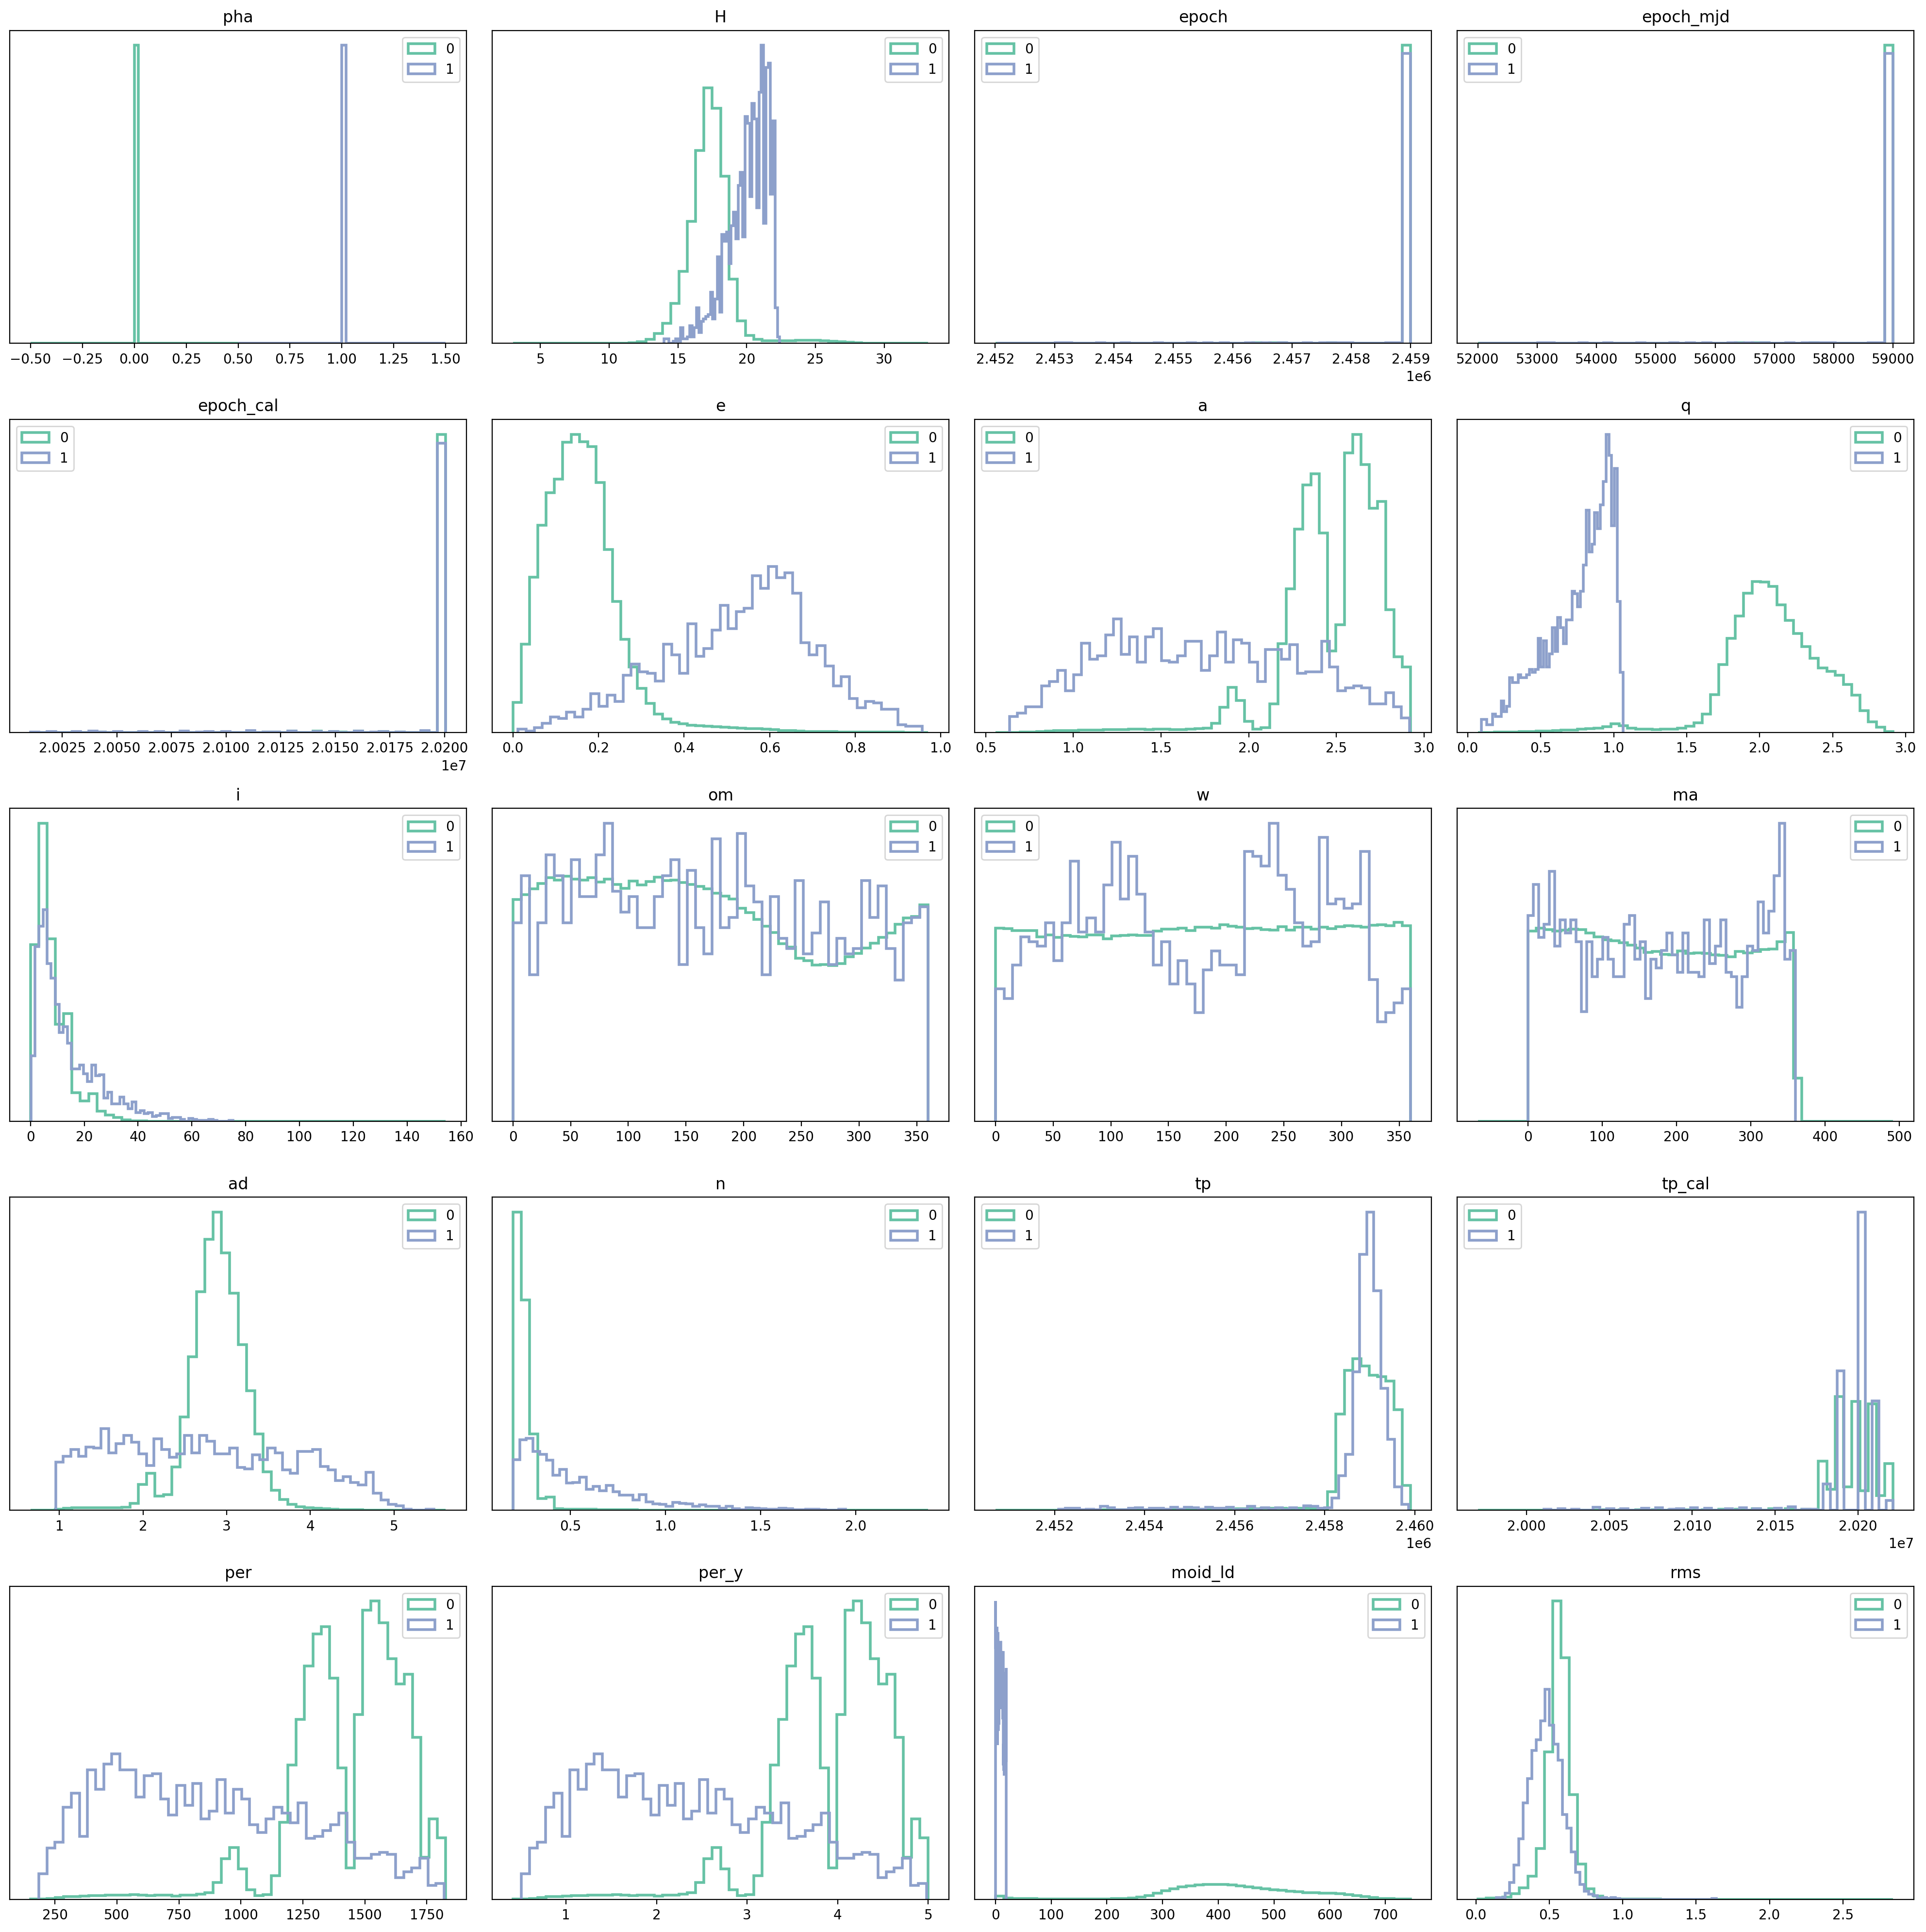

In [ ]:
fig, ax = plt.subplots(5, 4, figsize = (20, 20), dpi = 200)
for ind, (key, col) in enumerate(data.items()):
    plotable = ax[ind // 4][ind % 4]
    plotable.set_title(key)
    for ind_type, type in enumerate(data.pha.unique()):
        mask = data.pha == type
        if np.sum(col[mask].isna()) == len(col[mask]):
            break; 
        plotable.hist(col[mask], 
                      bins = 50, 
                      density = True, 
                      histtype = 'step', 
                      color = cm.Set2(ind_type / 3),
                      linewidth = 2,
                      label = type)
        plotable.set_yticks([])
        # plotable.axvline(np.mean(col[mask]), 
        #                  color = cm.Set1(ind_type / 3), 
        #                  label = f'Среднее тип {type}: {np.mean(col.dropna(inplace = False)):.2f}',
        #                  linestyle = '--')
        # plotable.axvline(np.median(col[mask]), 
        #                  color = cm.Set2(ind_type / 3), 
        #                  label = f'Медиана тип {type}: {np.median(col.dropna(inplace = False)):.2f}',
        #                  linestyle = '--')
        plotable.legend()
fig.tight_layout()

In [ ]:
print(np.sum(data.pha == 0))
print(np.sum(data.pha == 1))
print(np.sum(data.pha == 2))

662633
2024
0


__Разбиение на обучающую и тестовую выборки__

In [ ]:
X = data.drop('pha', axis = 1, inplace = False)
y = data['pha']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, shuffle = True)

In [ ]:
print(np.sum(y_train == 1))
print(np.sum(y_train == 2))
print(np.sum(y_train == 0))

1405
0
463854


(0.0, 0.2)

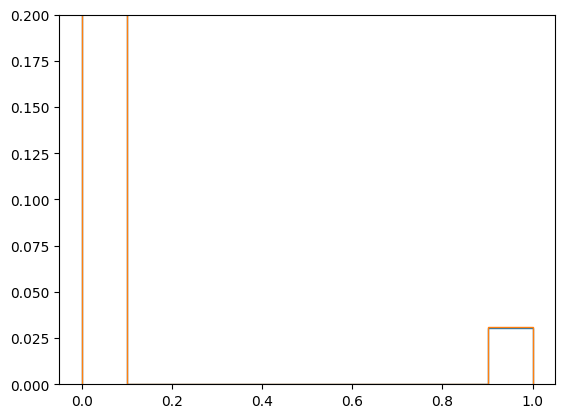

In [ ]:
plt.hist(y_train, density = True, histtype = 'step')
plt.hist(y_test, density = True, histtype='step')
plt.ylim(0, 0.2)

In [ ]:
scaler_X = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)

In [ ]:
model = linear_model.LogisticRegression(max_iter = int(1e6)).fit(X_train_scaled, y_train)

In [ ]:
prediction_test = model.predict(scaler_X.transform(X_test))
print(f'Процент правильных предсказаний {100 * np.sum((prediction_test == y_test)) / len(y_test):.2f} %')

Процент правильных предсказаний 99.87 %


In [ ]:
for class_t in data['pha'].unique():
    mask = y_test == class_t
    print(f'Точность предсказанимя класса {class_t}: {(np.sum((prediction_test[mask] == class_t))) /len(prediction_test[mask]) * 100:.2f} %') 

Точность предсказанимя класса 0: 99.96 %
Точность предсказанимя класса 1: 70.44 %


Как видим, модель оказалась достаточно точной. Высокая точность может быть связана как с хорошей предобработкой и правильным выбром модели, так и с большим дизбалансом классов. 

Точность предскзаания класса 1(наименее распространённого в датасете) наименьшая.

##### Модель 2 - регуляризация + стохастический градиентный спуск

Опыт(первые попытки запустить модель) показывает, что при большом дизбалансе классов модель не сходится.

Это связано с тем что при стохастическом градиентном спуске постоянно выбираются объекты только доминирующего класса.

Было принято решение случайным образом выбрать строки так, чтобы устранить дизбаланс:

In [ ]:
X = data.drop('pha', axis = 1, inplace = False)
y = data['pha']

mask = np.zeros(len(y))
mask[np.random.randint(size = 2000, low = 0, high = len(y))] = 1
mask += y == 1
mask = mask >=1
X_non_disbalanced = X[mask]
y_non_disbalanced = y[mask]
print(X_non_disbalanced.shape)
print(y_non_disbalanced.shape)

X_train_non_disbalanced, X_test, y_train_non_disbalanced, y_test = model_selection.train_test_split(X_non_disbalanced, y_non_disbalanced, test_size = 0.3, shuffle = True)

(4012, 19)
(4012,)


In [ ]:
X_train_non_disbalanced = scaler_X.fit_transform(X_train_non_disbalanced)

In [ ]:
X_test = scaler_X.transform(X_test)

y_test = y_test.to_numpy().astype(np.int64)

print(np.sum(y_train_non_disbalanced == 1))

print(np.sum(y_train_non_disbalanced == 0))

1432
1376


In [ ]:
y_train_non_disbalanced = y_train_non_disbalanced.to_numpy().astype(np.int64)

Модель логистической регрессии со стохастическим градиентным спуском реализована ниже. Чтобы ускорить функцию используется строгая типизация и библиотека `numba`, которая позволяет компилировать написанный на питоне код.

In [ ]:
@njit
def grad_dec(iter_depth, batch_size, alpha, learning_rate):
    learning_rate = np.float64(learning_rate)
    accuracy_test = np.ascontiguousarray(np.zeros(iter_depth, dtype = np.float64))
    accuracy_train = np.ascontiguousarray(np.zeros(iter_depth, dtype = np.float64))
    theta_zero = np.random.random(size = X_train_non_disbalanced[0].shape[0]) * 20
    theta = theta_zero.copy()
    for t in np.arange(iter_depth, dtype = np.int64):
        prediction_train = np.ascontiguousarray((1 / (1 + np.exp(-theta @ X_train_non_disbalanced.T)) > 0.5).astype(np.int64))
        accuracy_train[t] = np.sum(y_train_non_disbalanced == prediction_train) / y_train_non_disbalanced.shape[0]
        prediction_test = (1 / (1 + np.exp(-theta @ X_test.T)) > 0.5).astype(np.int64)
        accuracy_test[t] = np.sum(y_test == prediction_test) / y_test.shape[0]
        theta_new = np.ascontiguousarray(np.zeros_like(theta))
        for i in np.random.randint(size = batch_size,  low = 0, high = y_train_non_disbalanced.shape[0] - 1):
            theta_new += (y_train_non_disbalanced[i] - 1 / (1 + np.exp((-1) * theta @ X_train_non_disbalanced[i].T))) * X_train_non_disbalanced[i] 
        theta += learning_rate * theta_new - alpha * theta
    return accuracy_test, accuracy_train, theta

In [ ]:

# theta_zero = np.random.rand(X.shape[1]) * 5
# theta = theta_zero.copy()
learning_rate_values = [1e-3, 1e-2, 1e-5]
alpha_values = np.arange(0, 0.5, 0.05)
accuracy_test = {alpha: {rate: 0 for rate in learning_rate_values} for alpha in alpha_values}
accuracy_train = {alpha: {rate: 0 for rate in learning_rate_values} for alpha in alpha_values}
theta_values = {alpha: {rate: 0 for rate in learning_rate_values} for alpha in alpha_values}
batch_size, iter_depth = 256, int(1e3)

X_train_non_disbalanced, y_train_non_disbalanced = np.ascontiguousarray(X_train_non_disbalanced), np.ascontiguousarray(y_train_non_disbalanced)
X_test, y_test = np.ascontiguousarray(X_test), y_test

for alpha in alpha_values:
    for lr in learning_rate_values:
        print(lr)
        accuracy_test[alpha][lr], accuracy_train[alpha][lr], theta_values[alpha][lr] = grad_dec(iter_depth, batch_size, alpha, lr)
    

0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05
0.001
0.01
1e-05


In [ ]:
for alpha in alpha_values:
    print(f"Кф регуляризации: {alpha}")
    for lr in learning_rate_values:
        print(f"Итоговая точность модели при lr = {lr}: {np.sum((expit(theta_values[alpha][lr] @ X_test.T) > 0.5) == y_test) / len(y_test) * 100:.2f} %")

Кф регуляризации: 0.0
Итоговая точность модели при lr = 0.001: 97.18 %
Итоговая точность модели при lr = 0.01: 98.84 %
Итоговая точность модели при lr = 1e-05: 57.97 %
Кф регуляризации: 0.05
Итоговая точность модели при lr = 0.001: 98.01 %
Итоговая точность модели при lr = 0.01: 97.84 %
Итоговая точность модели при lr = 1e-05: 96.51 %
Кф регуляризации: 0.1
Итоговая точность модели при lr = 0.001: 98.01 %
Итоговая точность модели при lr = 0.01: 97.76 %
Итоговая точность модели при lr = 1e-05: 96.51 %
Кф регуляризации: 0.15000000000000002
Итоговая точность модели при lr = 0.001: 97.92 %
Итоговая точность модели при lr = 0.01: 97.43 %
Итоговая точность модели при lr = 1e-05: 96.10 %
Кф регуляризации: 0.2
Итоговая точность модели при lr = 0.001: 97.84 %
Итоговая точность модели при lr = 0.01: 97.09 %
Итоговая точность модели при lr = 1e-05: 95.60 %
Кф регуляризации: 0.25
Итоговая точность модели при lr = 0.001: 97.67 %
Итоговая точность модели при lr = 0.01: 98.09 %
Итоговая точность модел

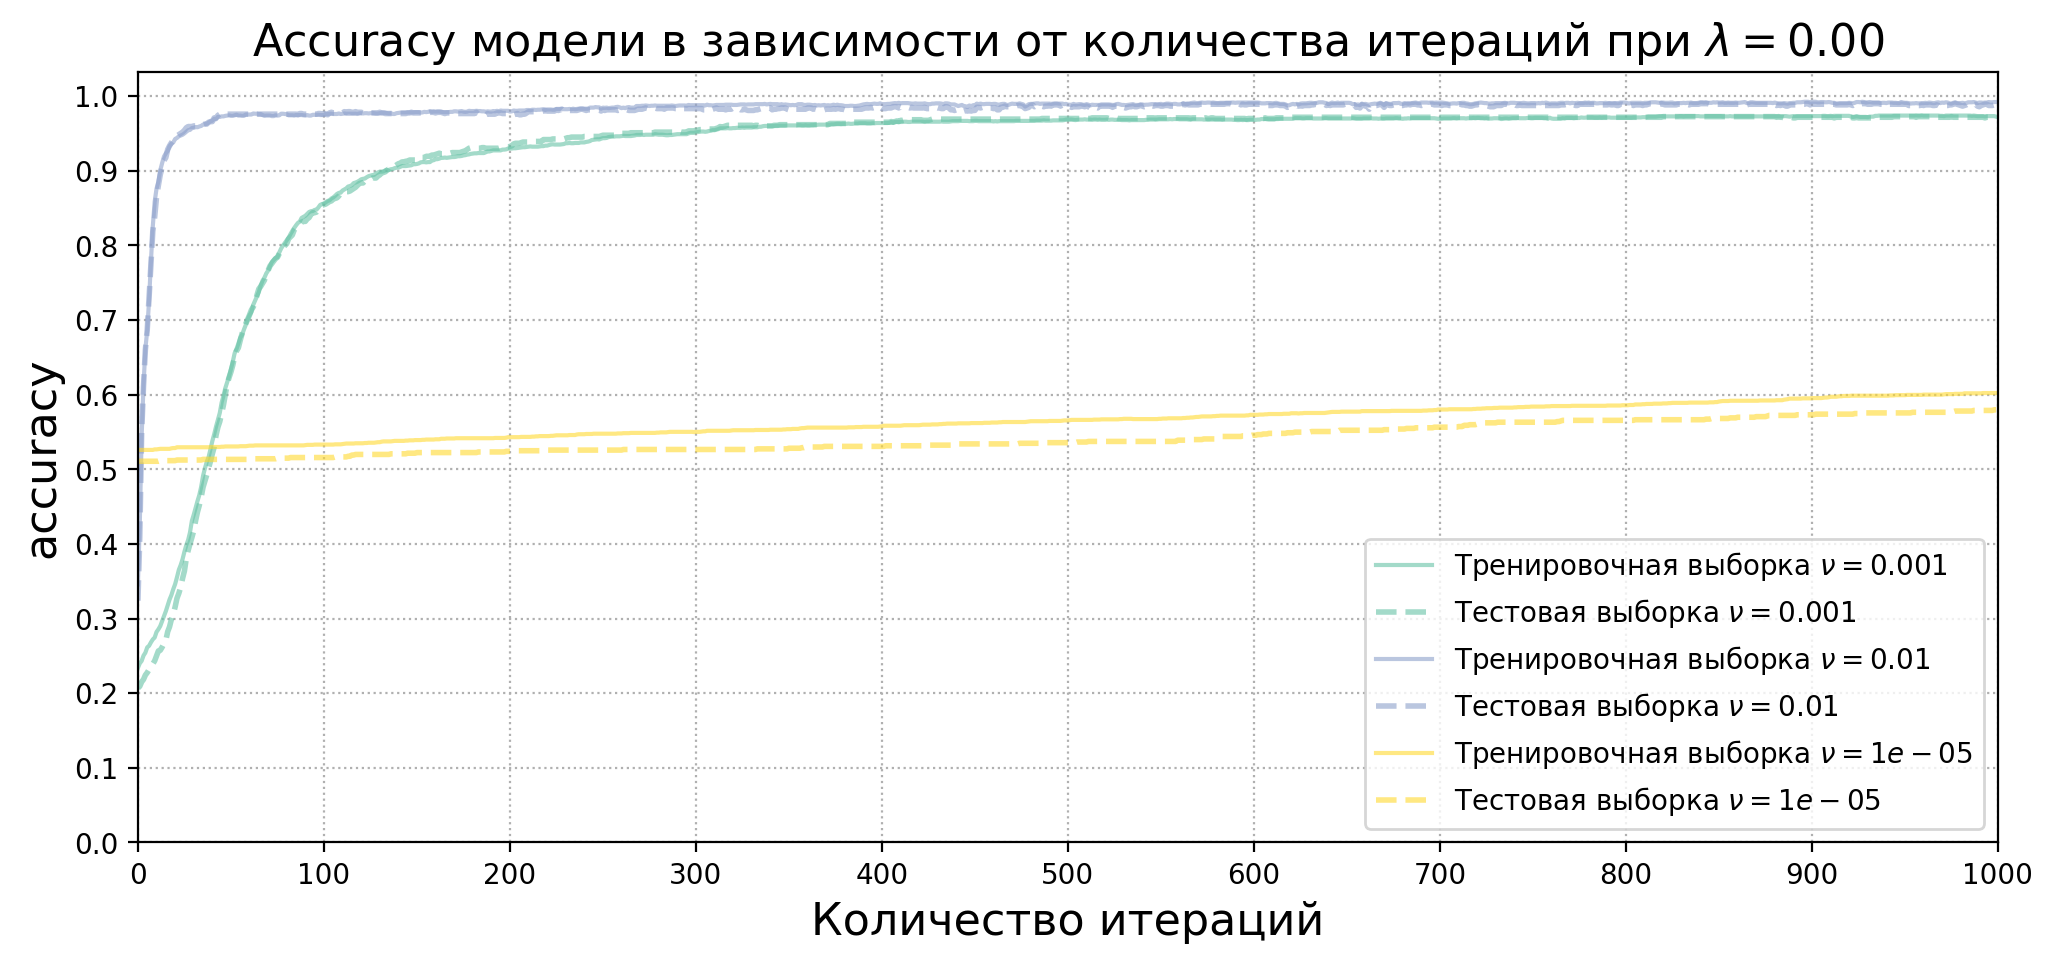

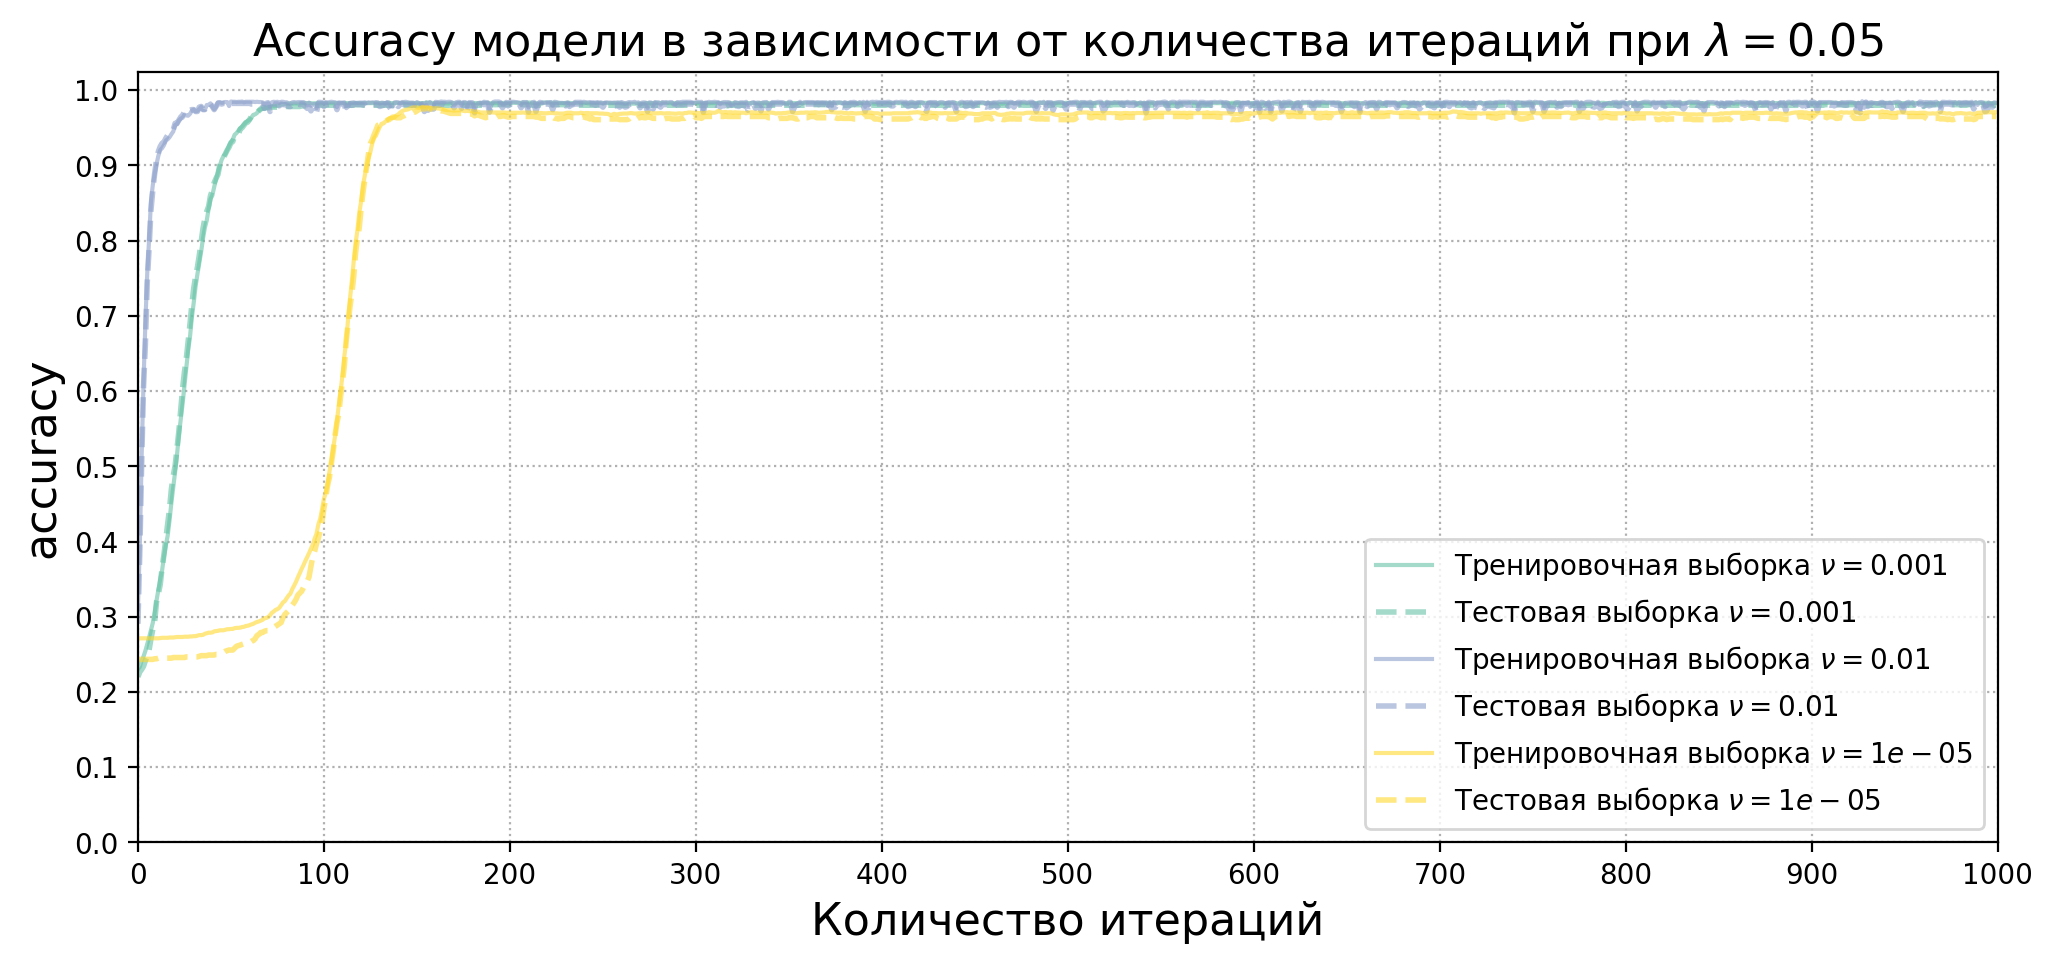

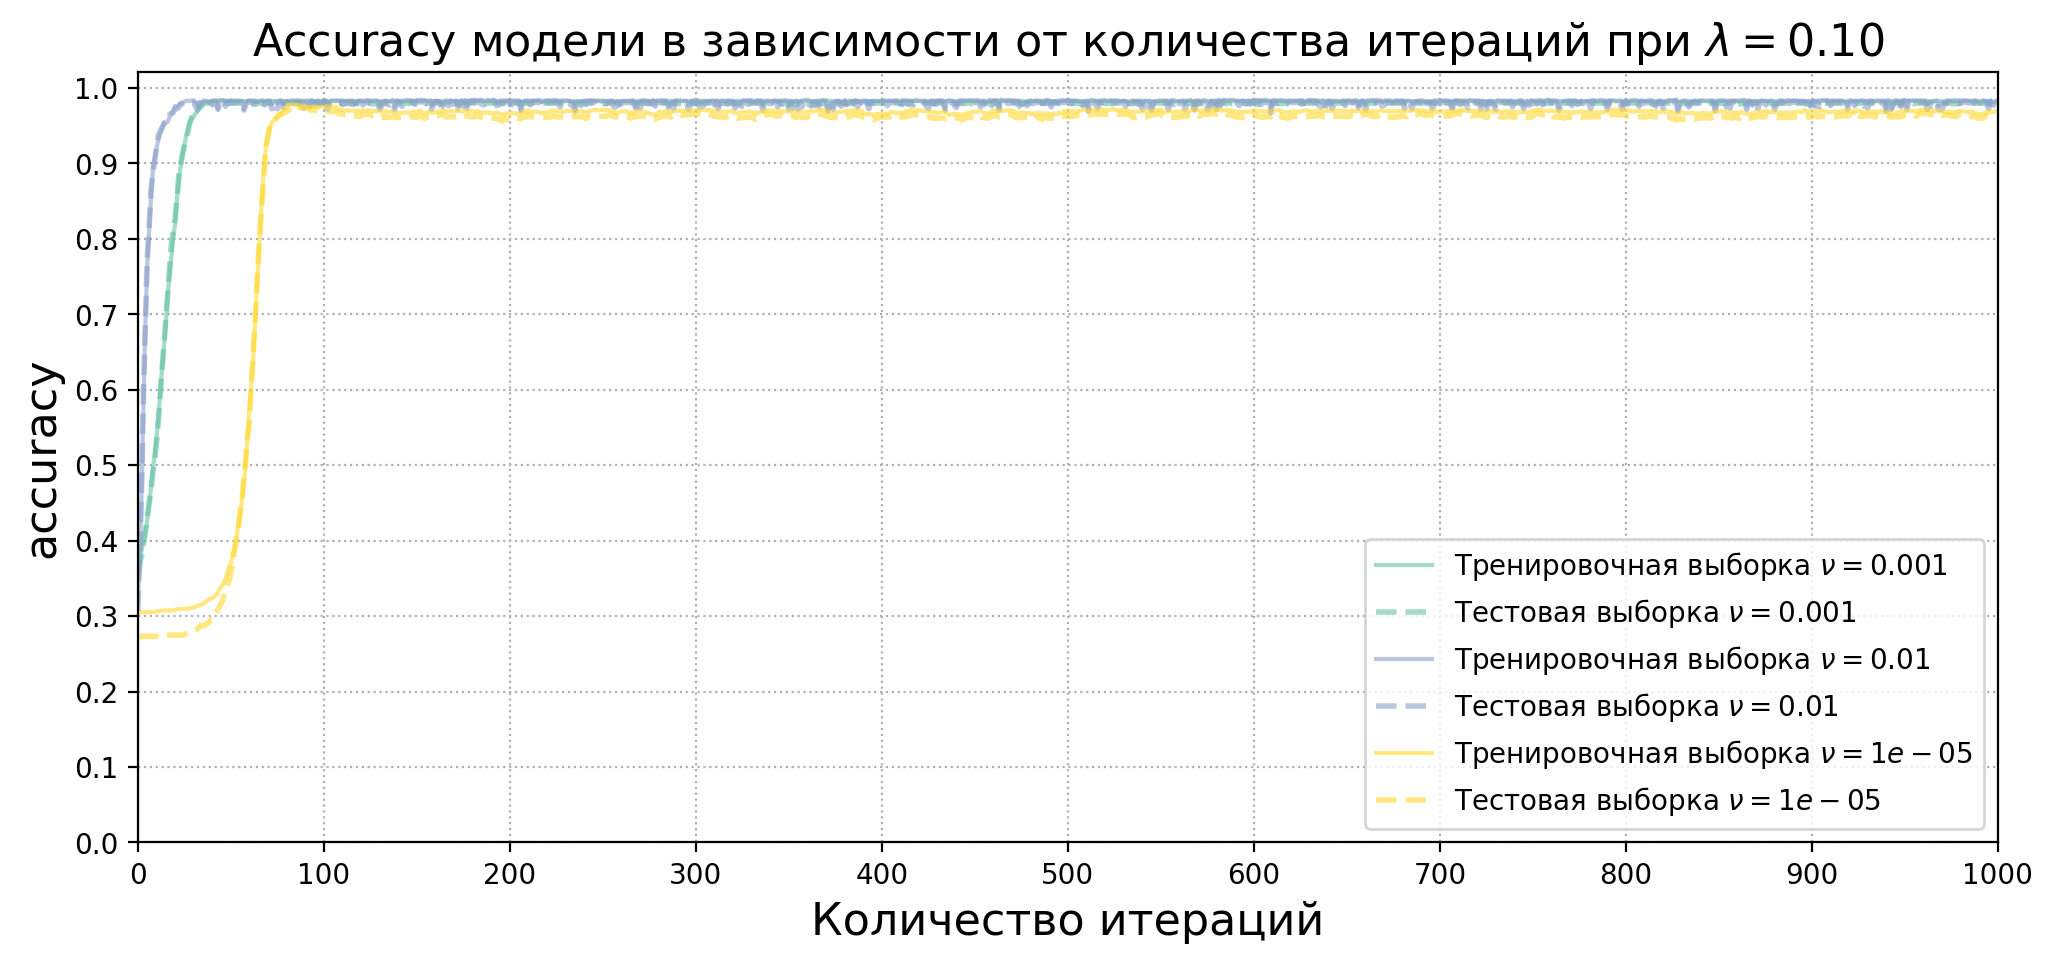

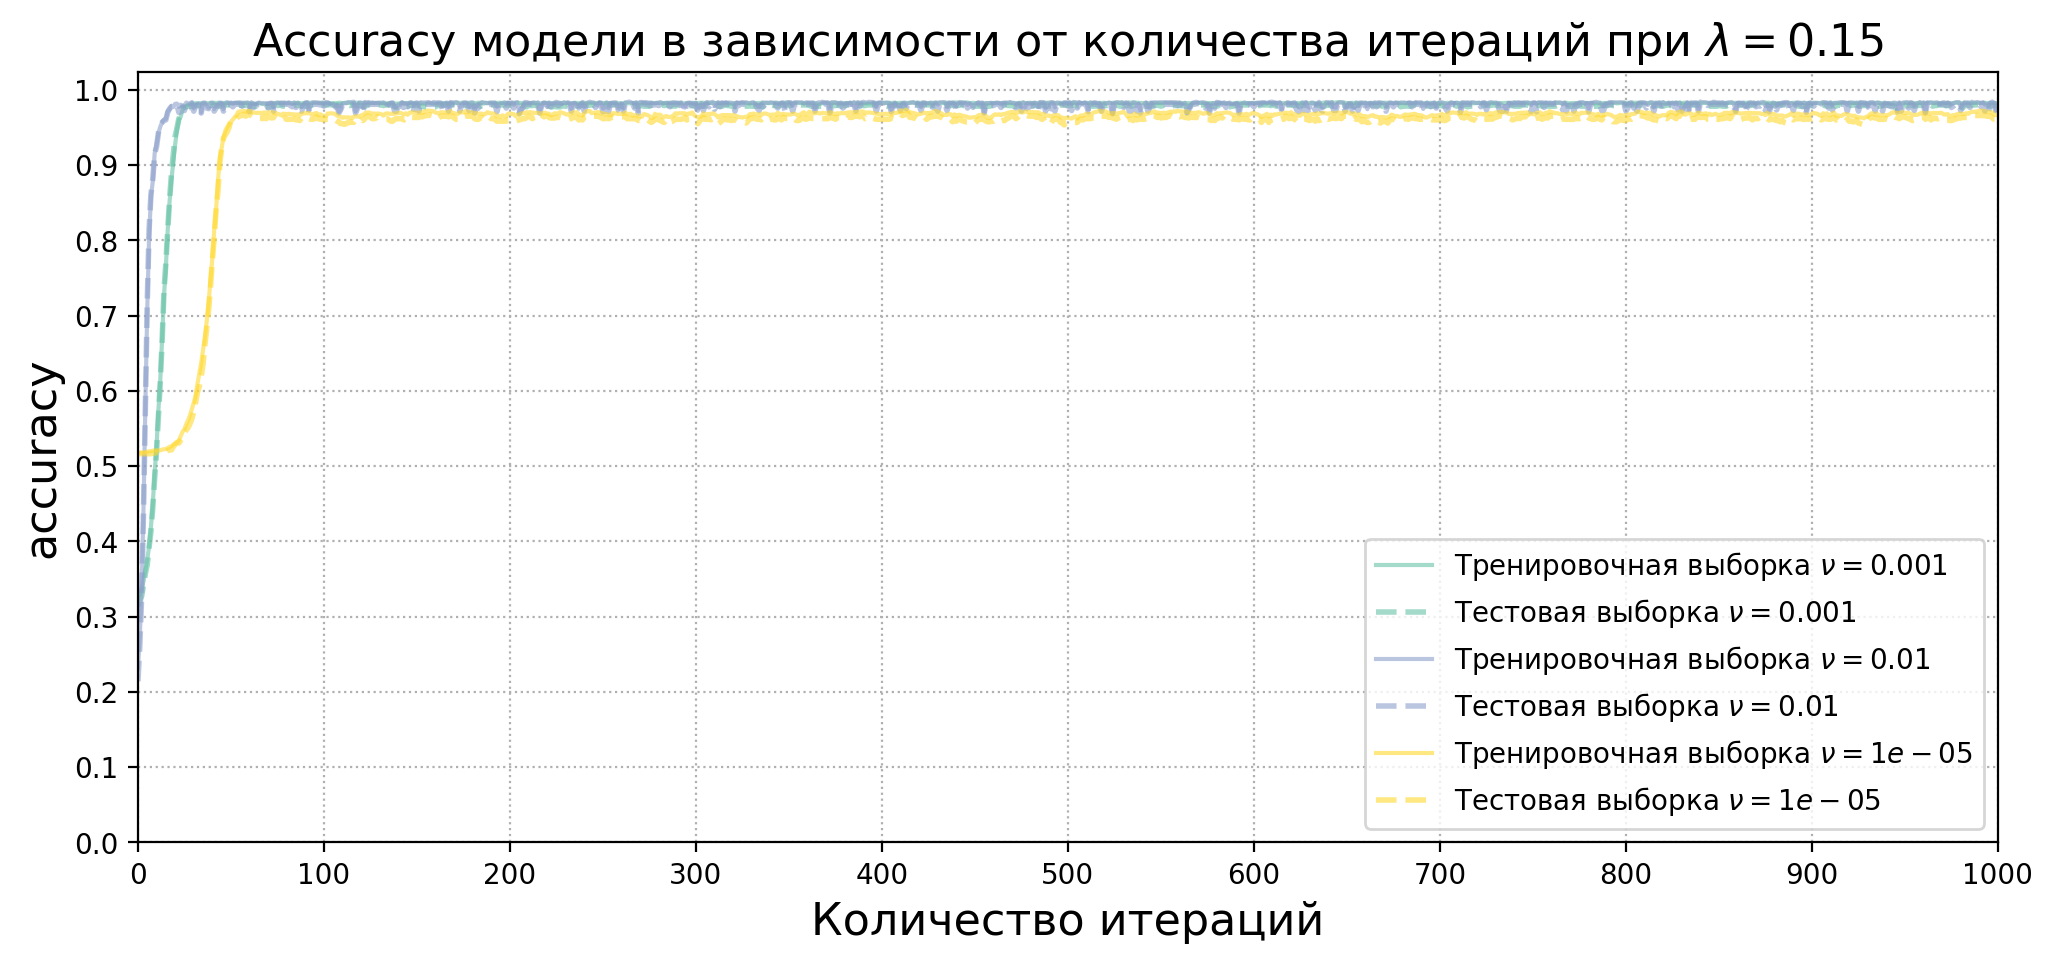

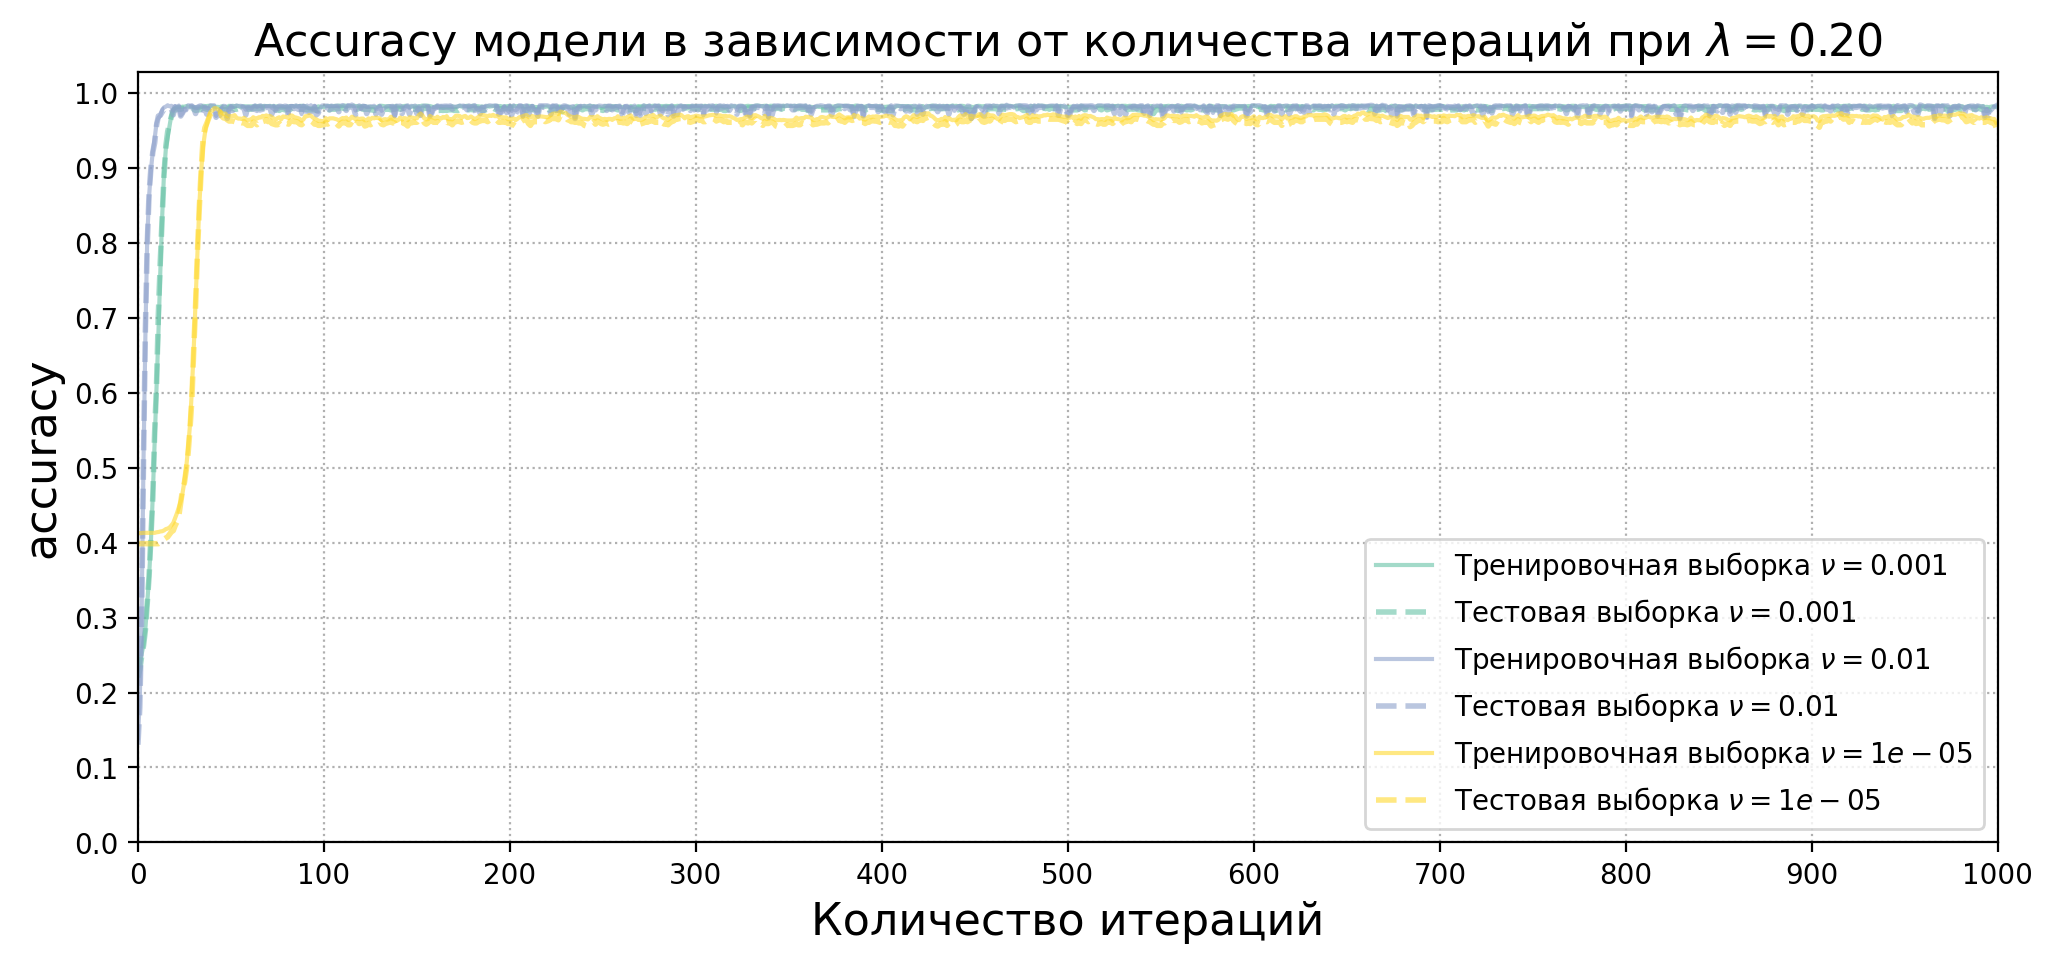

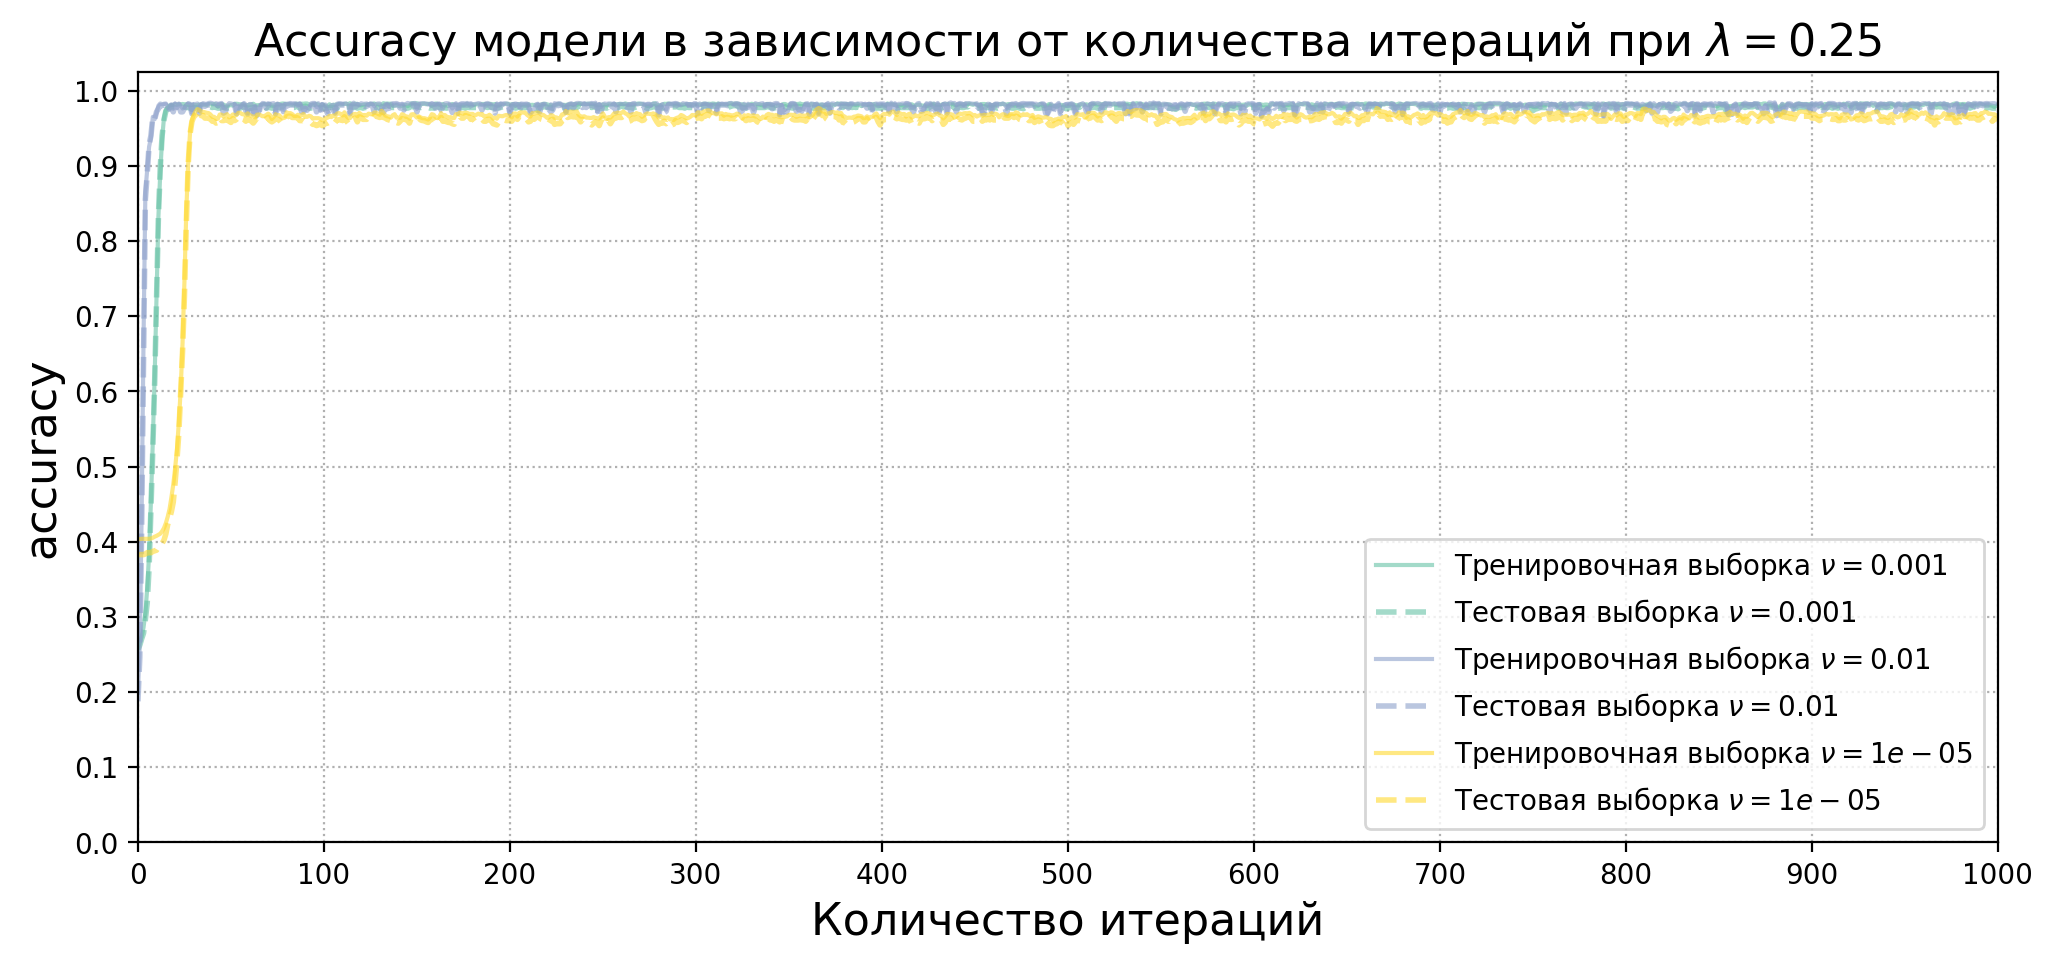

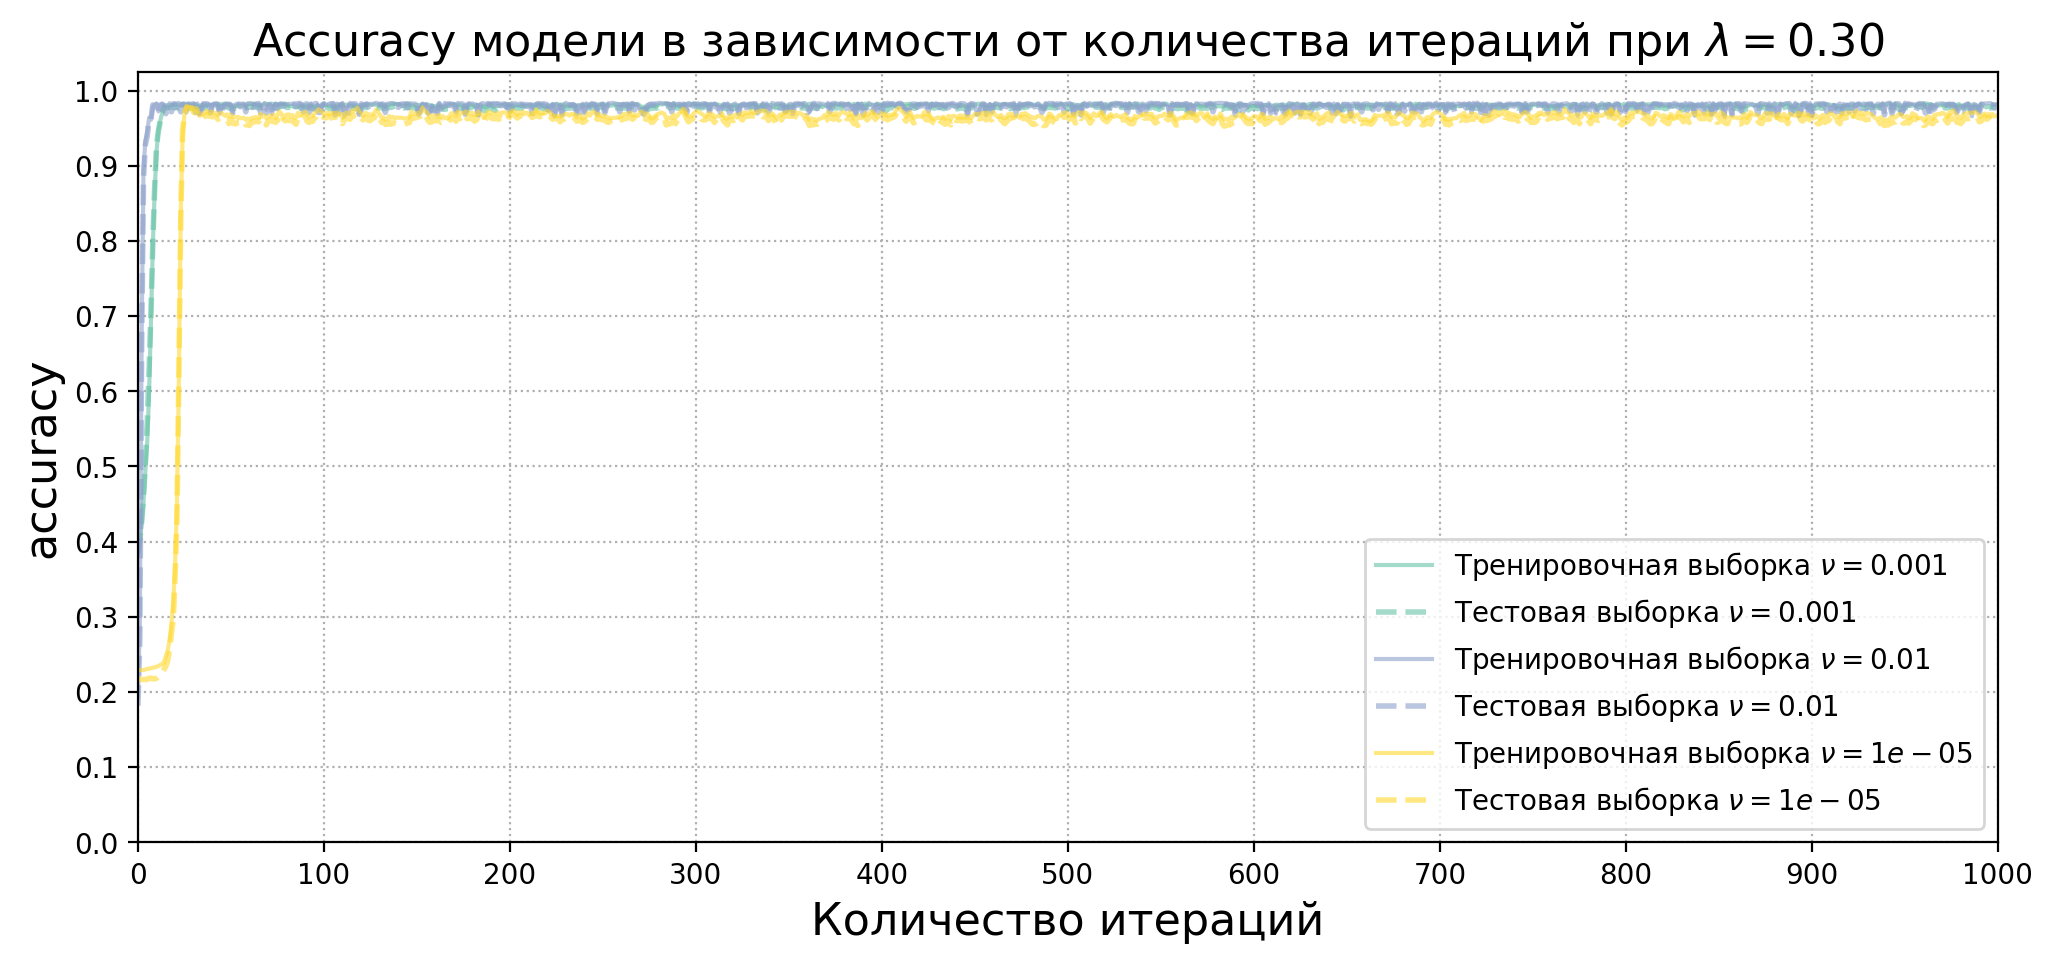

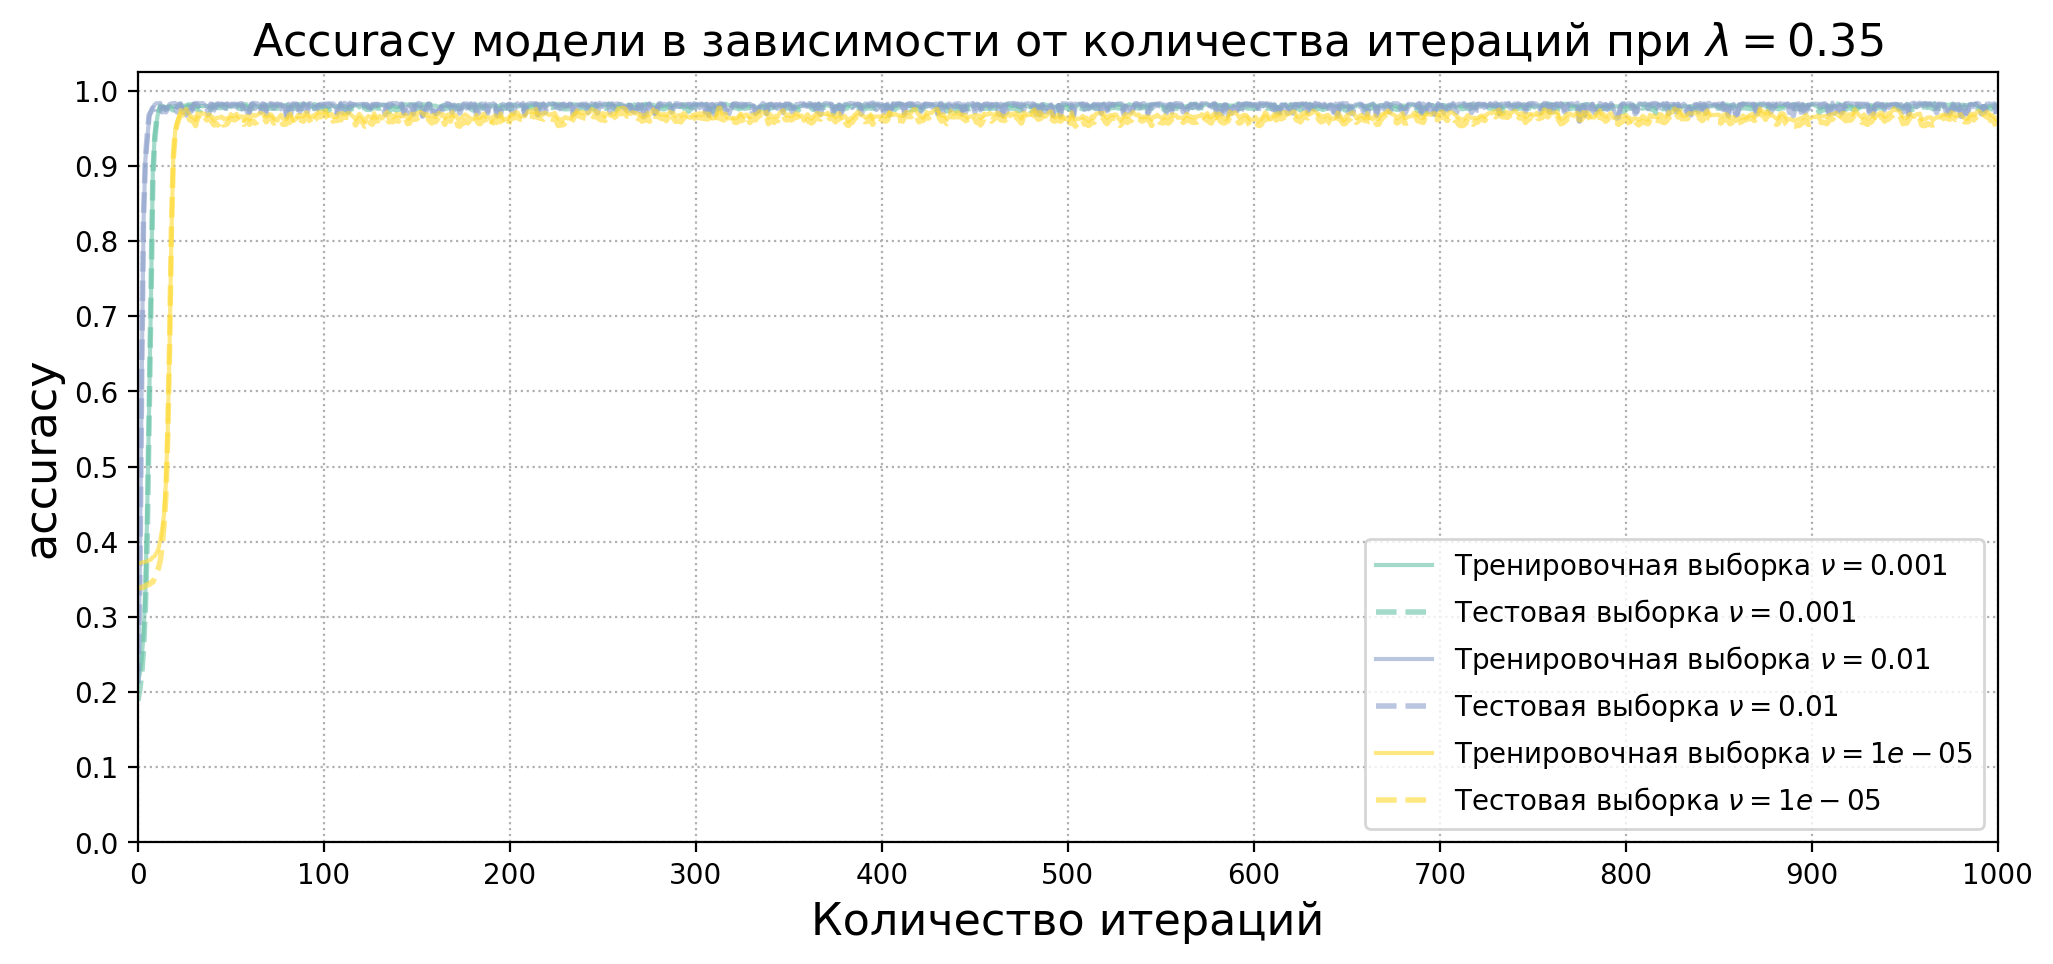

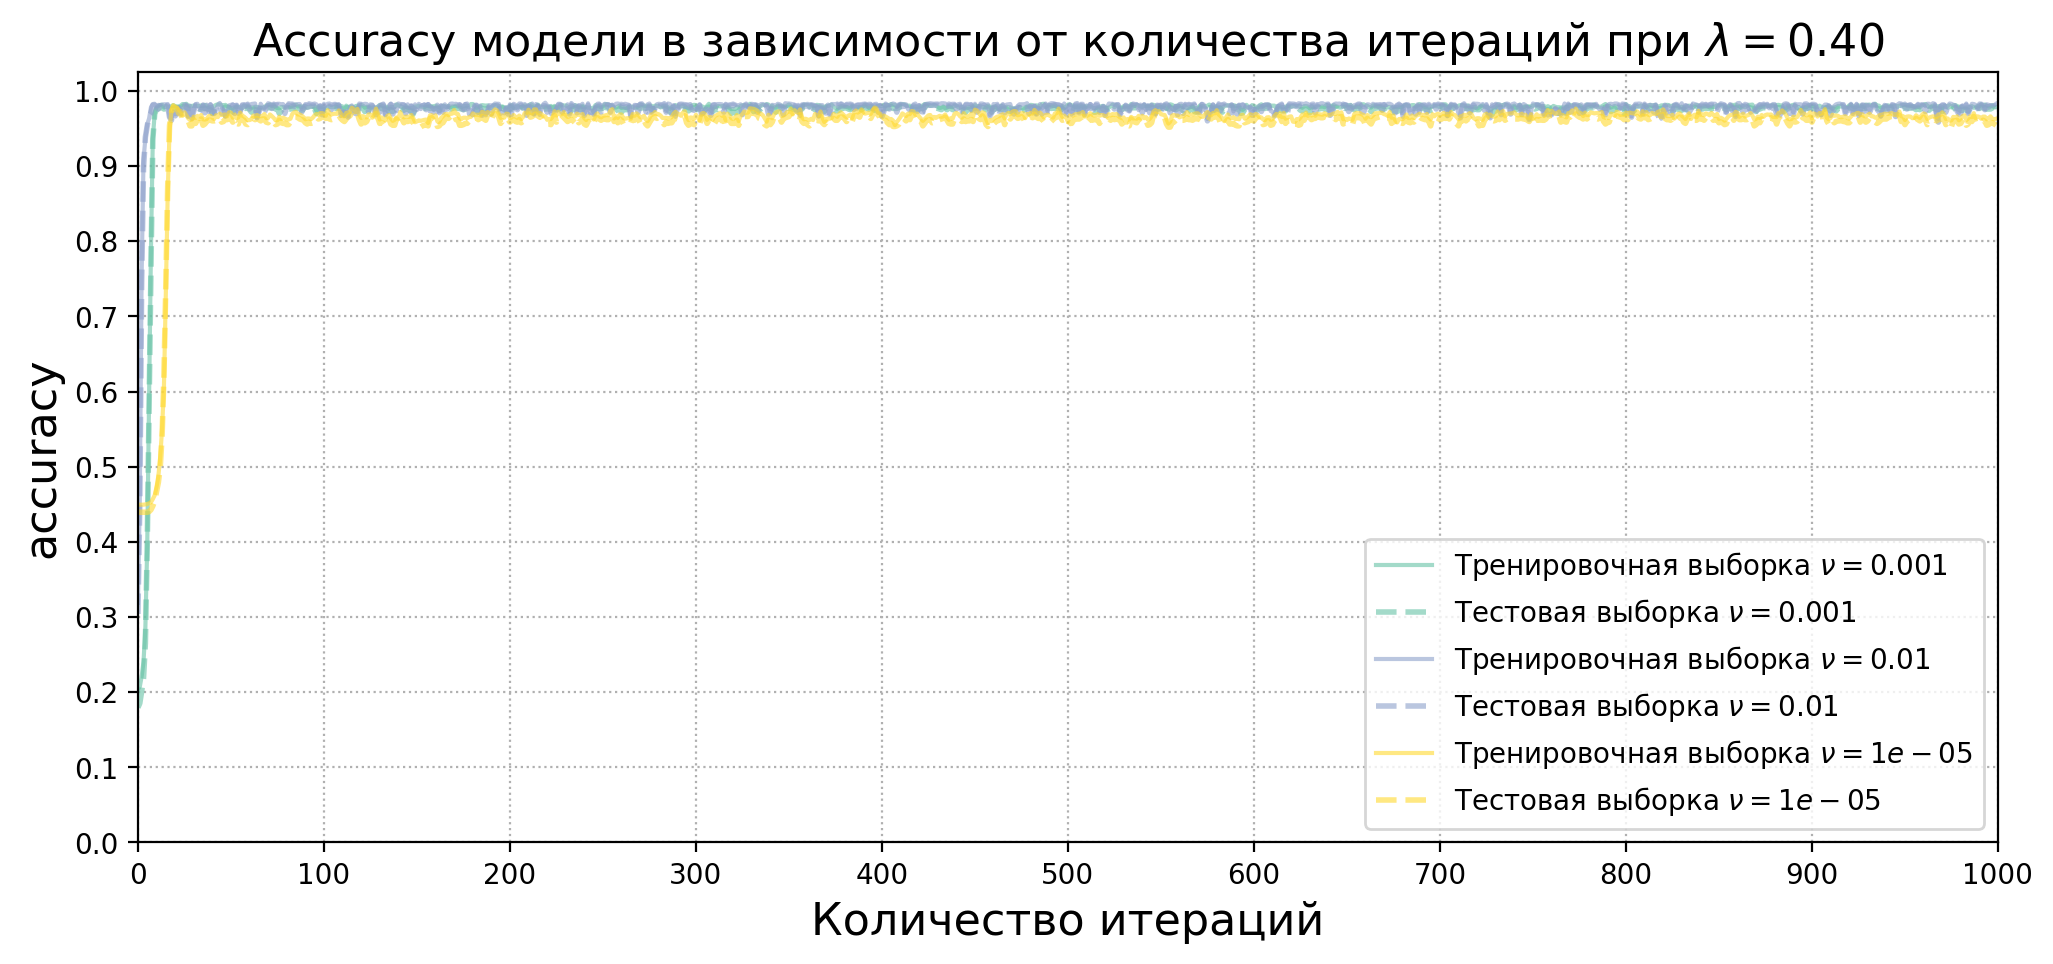

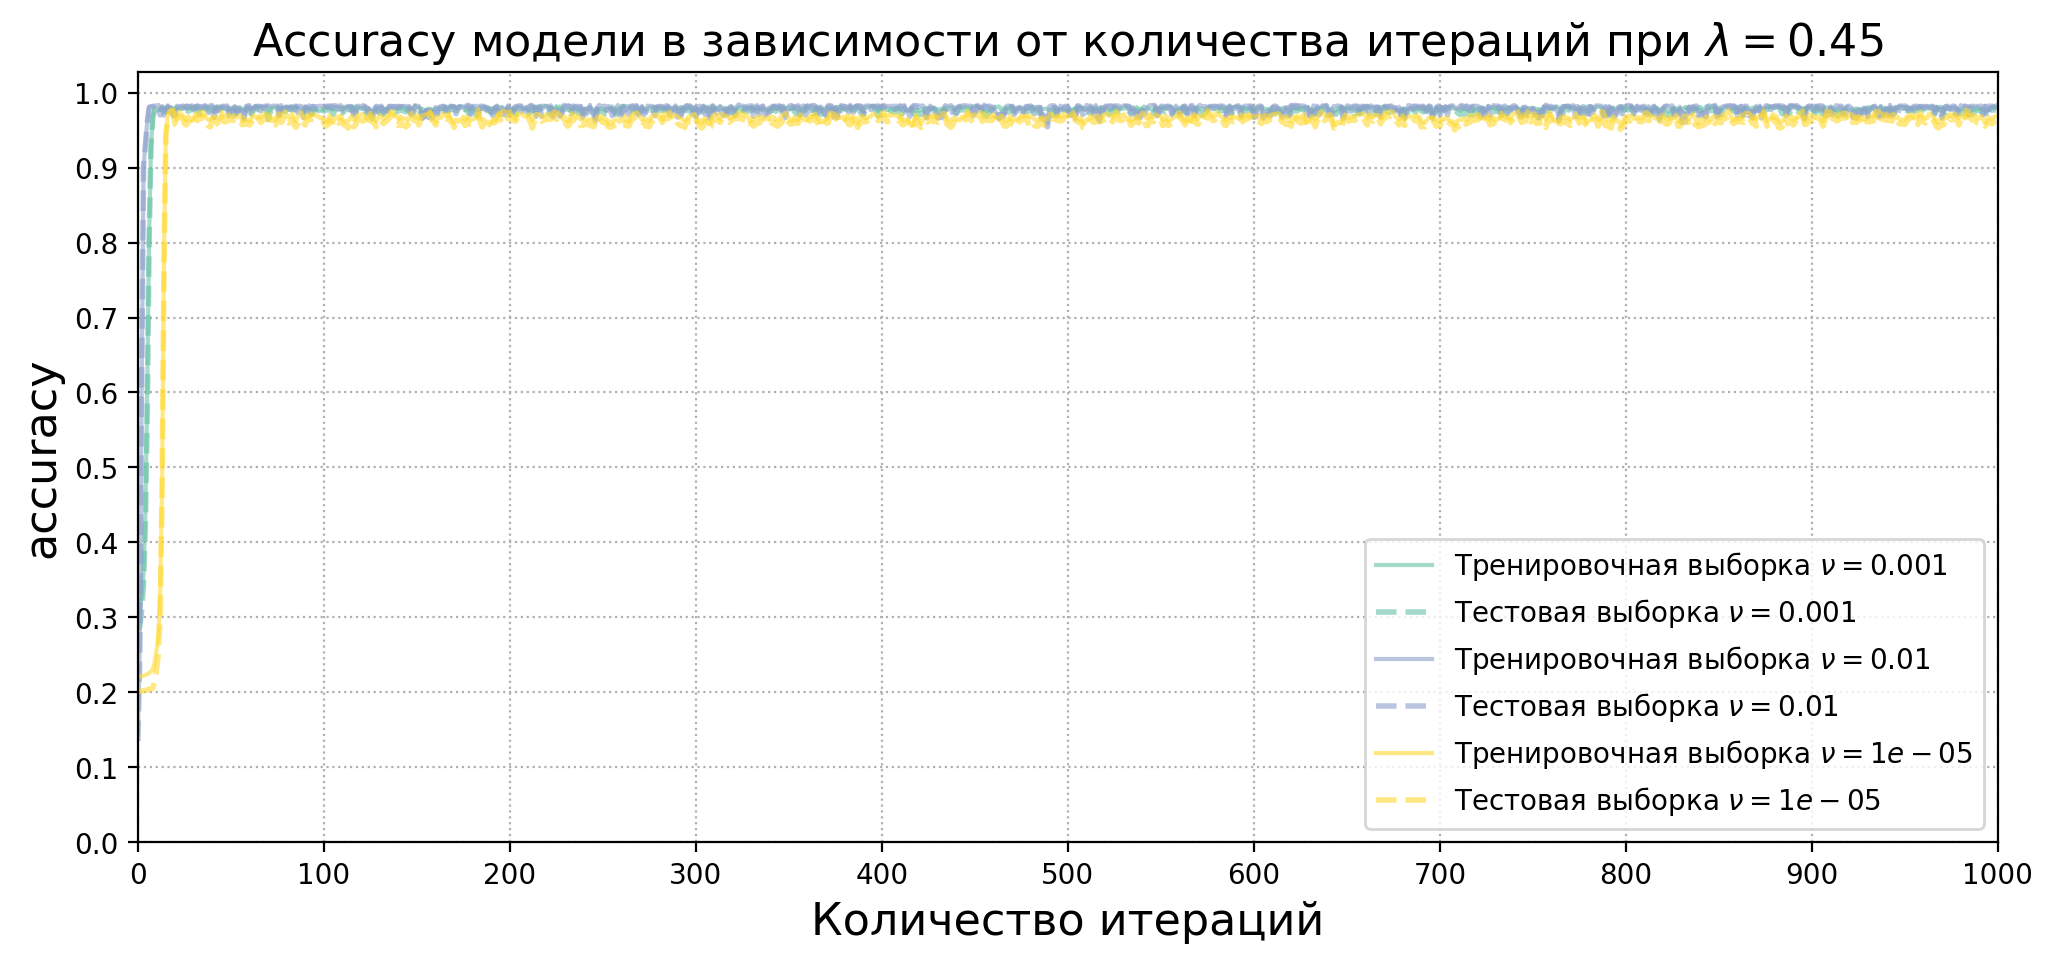

In [ ]:
for alpha in alpha_values:
    plt.figure(figsize = (12, 5), dpi = 200)

    for ind, learning_rate in enumerate(learning_rate_values):
        plt.plot(np.arange(iter_depth),
                accuracy_train[alpha][learning_rate], 
                label = r"Тренировочная выборка $\nu = {}$".format(learning_rate),
                color = cm.Set2(ind/len(learning_rate_values)),
                alpha = 0.6)

        plt.plot(np.arange(iter_depth),
                accuracy_test[alpha][learning_rate],
                label = r"Тестовая выборка $\nu = {}$".format(learning_rate),
                color = cm.Set2(ind/ len(learning_rate_values)),
                linestyle = '--',
                alpha = 0.6, 
                linewidth = 2)

    plt.plot()
    plt.legend(loc = 'lower right')
    plt.title(f"Accuracy модели в зависимости от количества итераций при $\lambda = {alpha:.2f}$",
            fontsize = 16)
    plt.ylabel("accuracy", fontsize = 16)
    plt.xlabel("Количество итераций", fontsize = 16)

    plt.xticks(np.arange(0, iter_depth + iter_depth // 10, iter_depth // 10))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(ls = ':')
    plt.xlim(0, iter_depth)
    plt.savefig(f'lr_{learning_rate}_lambda_{alpha}.png')

__Вывод__

В результате эксперимента было построено две модели.

Точность предсказания обеих моделей практически одинаковая.

Стоит отметить что модели с большим коэффициентом регуляризации сходятся быстрее(см графики выше). Однако когда кф регуляризации становится очень большим, метрика `accuracy` начинает осциллировать. При этом амплитуда осцилляций тем больше, чем больше коэффициент регуляризации.

Итоговые точности моделей представлены в таблице:


| Кф регуляризации | Точность при lr = 0.001 | Точность при lr = 0.01 | Точность при lr = 1e-05 |
|-------------------|---------------------------|--------------------------|---------------------------|
| 0.0               | 97.18 %                   | 98.84 %                  | 57.97 %                   |
| 0.05              | 98.01 %                   | 97.84 %                  | 96.51 %                   |
| 0.1               | 98.01 %                   | 97.76 %                  | 96.51 %                   |
| 0.15              | 97.92 %                   | 97.43 %                  | 96.10 %                   |
| 0.2               | 97.84 %                   | 97.09 %                  | 95.60 %                   |
| 0.25              | 97.67 %                   | 98.09 %                  | 95.93 %                   |
| 0.3               | 97.67 %                   | 98.09 %                  | 95.60 %                   |
| 0.35              | 97.67 %                   | 97.26 %                  | 95.68 %                   |
| 0.4               | 97.67 %                   | 97.76 %                  | 95.68 %                   |
| 0.45              | 97.67 %                   | 96.93 %                  | 96.43 %                   |
